In [1]:
import os
import warnings

import math
import pycbc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

warnings.filterwarnings('ignore')

/home/ashishthomas.mathew/.conda/envs/gengli_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
from modules import statistical_testing

In [3]:
glitches = pd.read_csv('./glitches/O3a_allifo.csv', usecols=['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'])
glitches = glitches[~glitches.duplicated(subset=['GPStime'], keep='first')]
glitches = glitches[glitches["ifo"] == "L1"]

glitches.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'], dtype='object')

# Testing our normality tests on a combined dataset of glitches and clean data

In this case we have a rather unique challenge where the data at hand is fairly unbalanced, with variations in the number of glitches and clean samples. Hence, for this case I'll take around 1000 samples of each to see how things go.

Our data with glitches has a lot more information to work with such as snr, duration and confidence, which we will not be taking into consideration for now since we want to look at what is common betwen clean and glitches samples.

Additionally our glitches are marked by particular GPS times around which we need to consider a time window to whiten and crop the sample into workable segments for our statistical tests. Our clean data is in the form of time segments of relative "silence" which we will have to process as is and divide into equally sized segments as our glitch data. 

## Loading the data

Let's generate this dataset below

In [4]:
glitch_count_df = glitches["label"].value_counts().rename_axis('Glitch Class').reset_index(name='Count')
glitch_count_df.to_latex("./outputs/glitch_counts.tex", index=False, float_format="%.0f", escape=False)

In [5]:
selection = glitches[(glitches['label'] == 'Tomte')]
samples = statistical_testing.fetch_glitch_data_from_csv(selection, begin=0, n_samples=10)

In [6]:
statistical_testing.display_sample_plots(samples.iloc[9], "./outputs/sample_plot.pdf")

Time elapsed for q-transform: 0.43 seconds


In [7]:
samples.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label',
       'unwhitened_y', 'whitened_y', 't', 'timeseries_file_location',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'glitch_present'],
      dtype='object')

In [8]:
sample_timeseries = TimeSeries.read(samples["timeseries_file_location"].iloc[0])

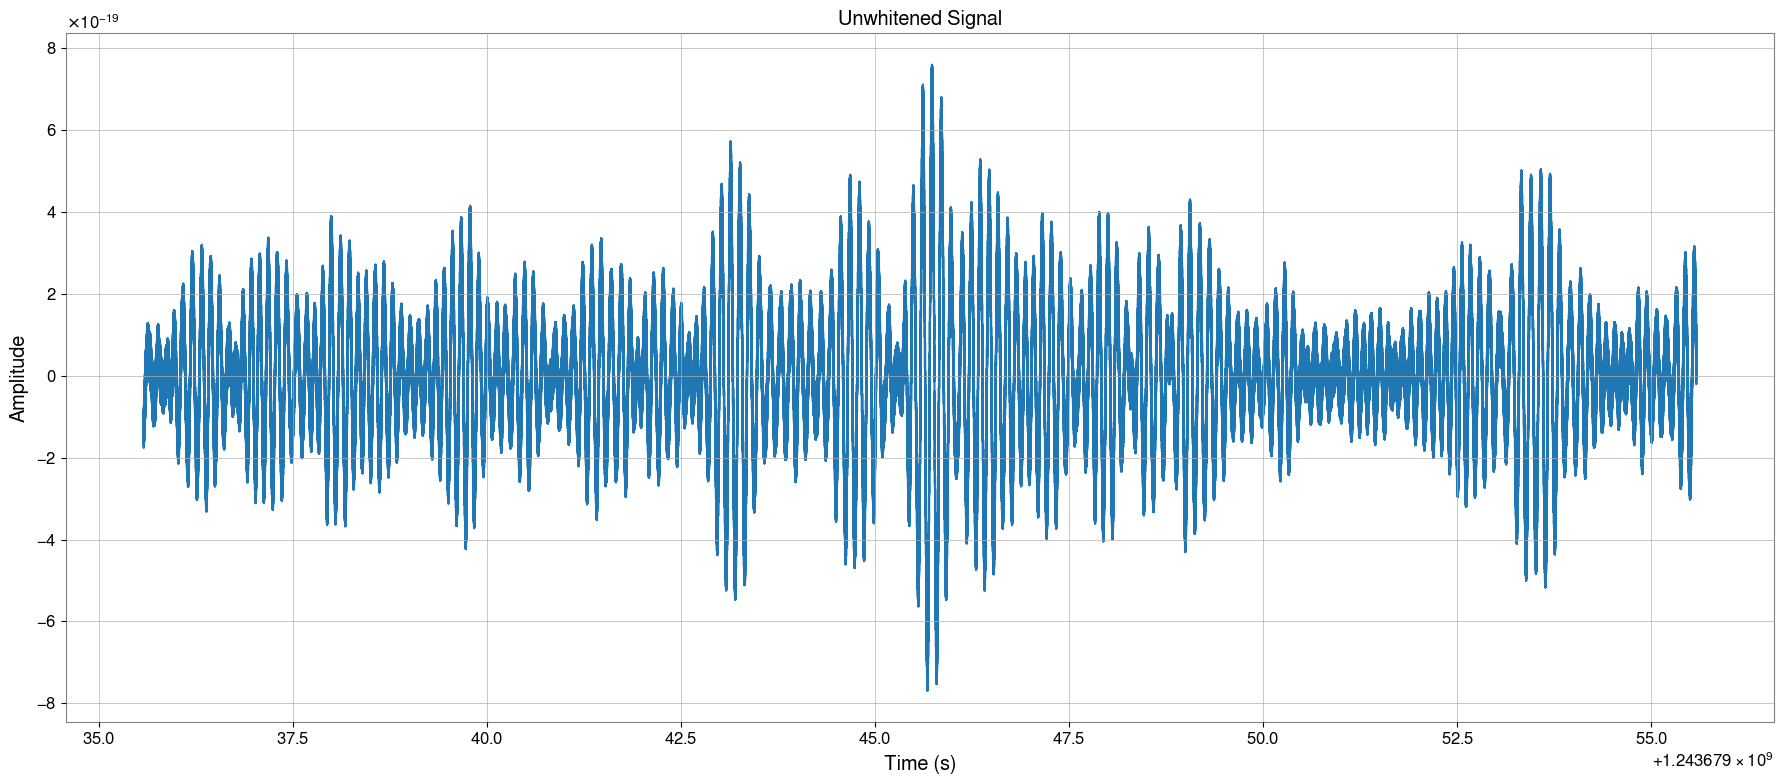

In [9]:
# plot the unwhitened y values for the first chirp
fig = plt.figure(figsize=(18, 8))
plt.plot(sample_timeseries.times, sample_timeseries.value)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Unwhitened Signal")
plt.tight_layout()
plt.savefig("./outputs/unwhitened_signal.pdf", dpi=100)

In [10]:
#whiten the timeseries
sample_timeseries_whitened = sample_timeseries.whiten(4,2)

In [11]:
sample_timeseries_whitened = sample_timeseries_whitened[int(4096*4):-int(4096*4)]

In [12]:
plt.figure(figsize=(18, 8))
plt.plot(sample_timeseries_whitened.times, sample_timeseries_whitened.value)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Whitened Signal")
plt.tight_layout()
plt.savefig("./outputs/whitened_signal.pdf", dpi=100)

In [13]:
sample_asd = sample_timeseries.asd(4, 2)

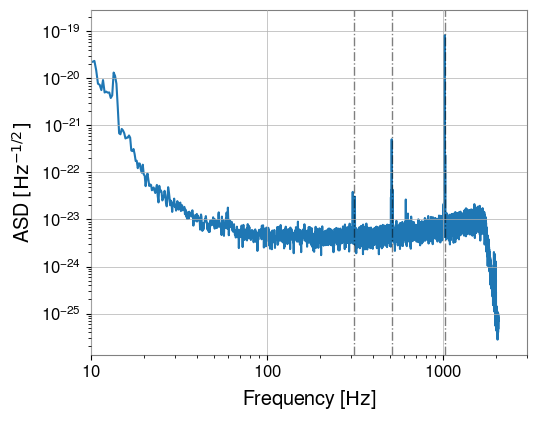

In [14]:
plot = sample_asd.plot()
ax = plot.gca()
ax.set_xlim(10, 3000)
# ax.set_ylim(5e-26, 1e-21)

#plot dotted lines at 512 Hz and 1024Hz
ax.axvline(x=310, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.axvline(x=510, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.axvline(x=1020, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.set_ylabel("ASD $[\mathrm{Hz}^{-1/2}]$")

plot.savefig("./outputs/unwhitened_asd.pdf", dpi=100)

In [15]:
labels = ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip',
       'Blip_Low_Frequency', 'Chirp', 'Extremely_Loud',
       'Fast_Scattering', 'Helix', 'Koi_Fish',
       'Light_Modulation', 'Low_Frequency_Burst',
       'Low_Frequency_Lines', 'Paired_Doves',
       'Power_Line', 'Repeating_Blips', 'Scattered_Light',
       'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line',
       'Whistle', 'clean_signal']

columns = [
    'label', "shapiro_TP", "shapiro_FN",
    "shapiro_FP", "shapiro_TN", "shapiro_accuracy", "shapiro_recall", "shapiro_fpr",
    "shapiro_precision", "shapiro_f1_score", "KS_TP",
    "KS_FN", "KS_FP", "KS_TN",
    "KS_accuracy", "KS_recall", "KS_fpr", "KS_precision",
    "KS_f1_score", "AD_TP", "AD_FN", "AD_FP", "AD_TN",
    "AD_accuracy", "AD_recall", "AD_fpr", "AD_precision", "AD_f1_score"]


def generate_glitchwise_confusion_matrices(df):

    scaler = StandardScaler()

    confusion_matrix_df = pd.DataFrame(columns=columns)
    for label in labels:
        temp_df = df[df['label'] == label]

        # print(f"Loading {label} data...")

        # temp_df = statistical_testing.fetch_glitch_data_from_csv(temp_df, tw=10, bandpass=bandpass, low_freq=low_feq, high_freq=high_freq)
        # temp_df.dropna(inplace=True)

        # print(f"Generating confusion matrix for {label}...")
        shapiro_cm = statistical_testing.generate_confusion_matrix(temp_df)
        ks_cm = statistical_testing.generate_confusion_matrix(temp_df, "KS")
        ad_cm = statistical_testing.generate_confusion_matrix(temp_df, "Anderson")

        shapiro_metrics = list(statistical_testing.generate_evaluation_metrics(shapiro_cm))
        ks_metrics = list(statistical_testing.generate_evaluation_metrics(ks_cm))
        ad_metrics = list(statistical_testing.generate_evaluation_metrics(ad_cm))

        shapiro_cm = shapiro_cm.flatten()
        ks_cm = ks_cm.flatten()
        ad_cm = ad_cm.flatten()

        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[label] + shapiro_cm.tolist() + shapiro_metrics + ks_cm.tolist() + ks_metrics + ad_cm.tolist() + ad_metrics], columns=columns)], ignore_index=True)

    return confusion_matrix_df
    

In [16]:
def generate_testwise_confusion_matrix(df):

    confusion_matrix_df = pd.DataFrame(columns=["Test","TP","FN","FP","TN","Accuracy","Recall(TPR/Sensitivity)", "FPR","Precision","F1 Score"])
    for test in ["Shapiro", "KS", "Anderson"]:
        # print(f"Generating confusion matrix for {test}...")
        cm = statistical_testing.generate_confusion_matrix(df, test)
        metrics = list(statistical_testing.generate_evaluation_metrics(cm))
        cm = cm.flatten()
        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[test] + cm.tolist() + metrics], columns=confusion_matrix_df.columns)], ignore_index=True)
    
    return confusion_matrix_df

In [17]:
# Loading up the clean segments
clean_gpstimes = pd.read_csv("./clean_segments/pre_clean_segments_O3a_L1.csv", usecols=['start_time', 'end_time', 'p_values'])

# Loading up the glitch data times and randomly sampling 51 glitches from each label
sample_glitches = pd.read_csv('./glitches/DQ_glitches_O3a.csv', usecols=['GPStime', 'ifo', 'label','snr'])
# Excluide 'no_glitch' label
sample_glitches = sample_glitches[sample_glitches['label'] != 'No_Glitch']
sample_glitches = sample_glitches[~sample_glitches.duplicated(subset=['GPStime'], keep='first')]


if not os.path.isfile("./glitches/random_samples.csv"):
    sample_glitches_df = sample_glitches[sample_glitches['ifo'] == 'L1'].groupby('label').apply(lambda x: x.sample(n=min(len(x),101))).reset_index(drop=True)
    sample_glitches_df.to_csv("./glitches/random_samples.csv", index=False)
else:
    sample_glitches_df = pd.read_csv("./glitches/random_samples.csv", index_col=False)

In [18]:
sample_glitches_df.head()

GPStime      snr ifo      label
0 1243645823.14600 10.26000  L1  1080Lines
1 1243586559.13700 11.94400  L1  1080Lines
2 1248843684.68100  8.48800  L1  1080Lines
3 1246314144.06300 12.84000  L1  1080Lines
4 1252075134.94000  9.38500  L1  1080Lines

In [19]:
def create_combined_glitch_clean_df(clean_gpstimes, sample_glitches_df, n_samples=1000, whitening_tw: int=10, observation_tw: float = 1, segment_duration_seconds: float=1, bandpass=False, low_freq=10, high_freq=250):
    clean_samples_df = statistical_testing.fetch_clean_segment_samples(clean_gpstimes, n_samples=n_samples, segment_duration_seconds=segment_duration_seconds, bandpass=bandpass, low_freq=low_freq, high_freq=high_freq)
    sample_glitches_df = statistical_testing.fetch_glitch_data_from_csv(sample_glitches_df, whitening_tw=whitening_tw, observation_tw=observation_tw, bandpass=bandpass, low_freq=low_freq, high_freq=high_freq)

    print(clean_samples_df.columns)
    print(sample_glitches_df.columns)
    # , 'shapiro_prediction', 'ks_prediction', 'ad_prediction'
    sample_glitches_df = sample_glitches_df[['whitened_y', 'unwhitened_y', 't', "timeseries_file_location", 'shapiro_statistic', 'shapiro_pvalue',
	    'ks_statistic', 'ks_pvalue', 'ad_statistic',
	    'ad_critical_values', 'ad_significance_level', 'kurtosis', 'skew',
	    'ifo', 'label', 'glitch_present', 'snr']]

    sample_glitches_df = sample_glitches_df.dropna()
    clean_samples_df = clean_samples_df.dropna()

    # Combining the clean and glitch data
    combined_df = pd.concat([clean_samples_df, sample_glitches_df], ignore_index=True)
    
    return combined_df

In [20]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [22]:
combined_df[combined_df.isna().any(axis=1)].head()

Empty DataFrame
Columns: [whitened_y, t, timeseries_file_location, unwhitened_y, shapiro_statistic, shapiro_pvalue, ks_statistic, ks_pvalue, ad_statistic, ad_critical_values, ad_significance_level, kurtosis, skew, ifo, label, glitch_present, snr]
Index: []

In [23]:
len(combined_df)

3593

In [24]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['shapiro_pvalue'])

In [25]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['ks_pvalue'], "KS")

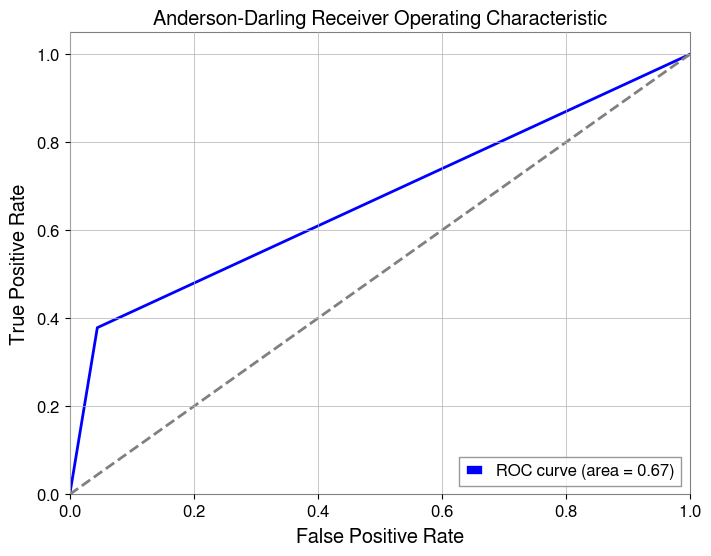

In [26]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df[['ad_statistic','ad_critical_values']], "Anderson")

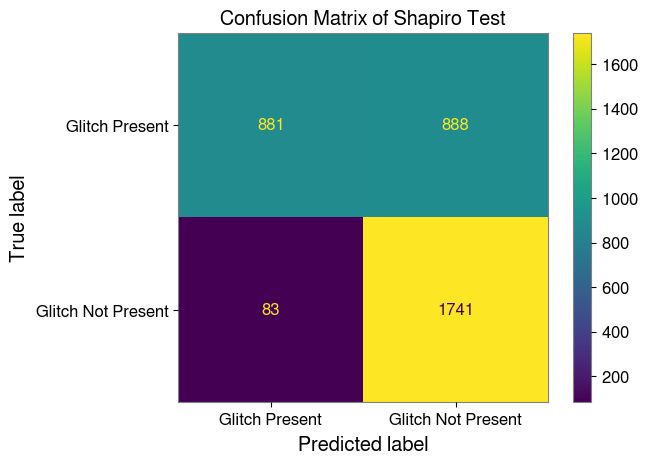

In [27]:
statistical_testing.display_confusion_matrix(combined_df)

In [28]:
statistical_testing.display_confusion_matrix(combined_df, "KS")

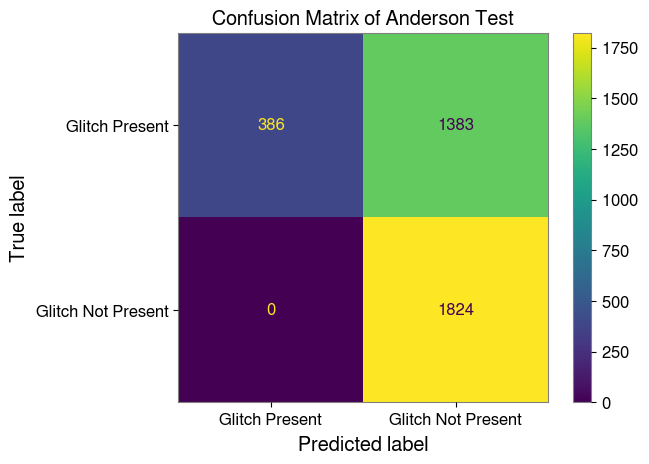

In [29]:
statistical_testing.display_confusion_matrix(combined_df, "Anderson")

I will now perform the same tests using a band pass filter

In [ ]:
bp_combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=10, high_freq=1000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


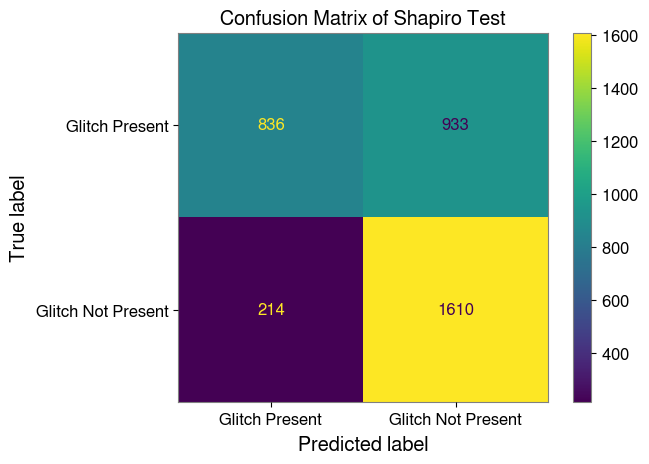

In [31]:
statistical_testing.display_confusion_matrix(bp_combined_df)

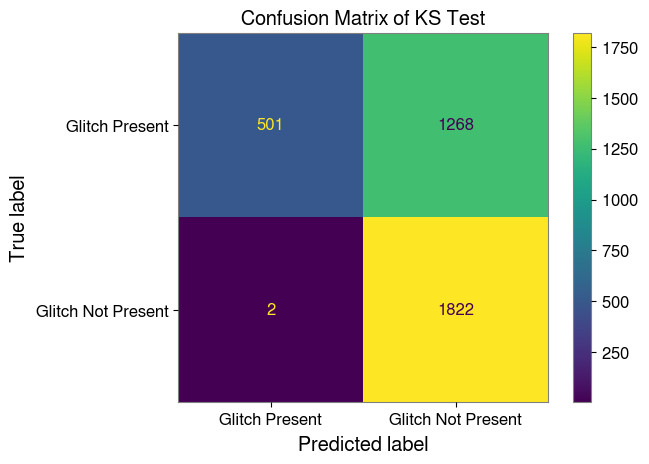

In [32]:
statistical_testing.display_confusion_matrix(bp_combined_df, "KS")

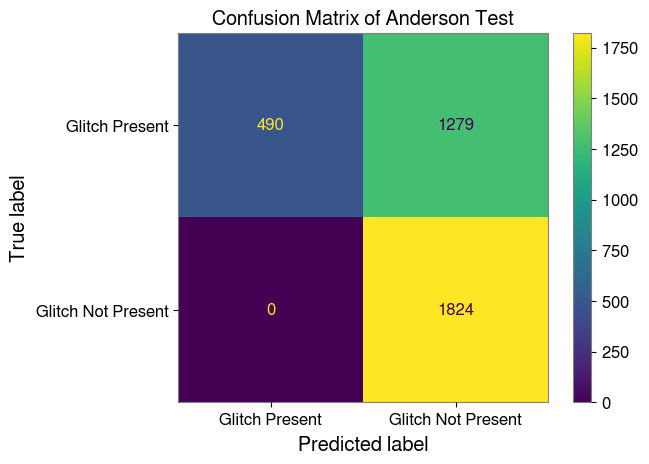

In [33]:
statistical_testing.display_confusion_matrix(bp_combined_df, "Anderson")

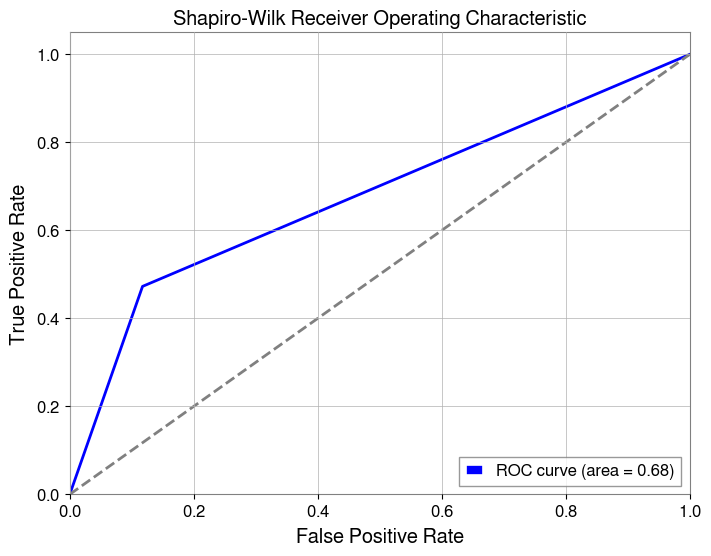

In [34]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df['shapiro_pvalue'])

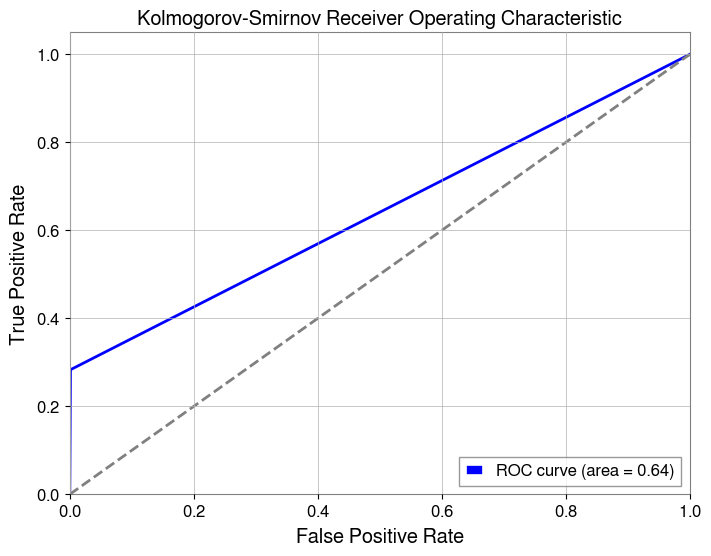

In [35]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df['ks_pvalue'], "KS")

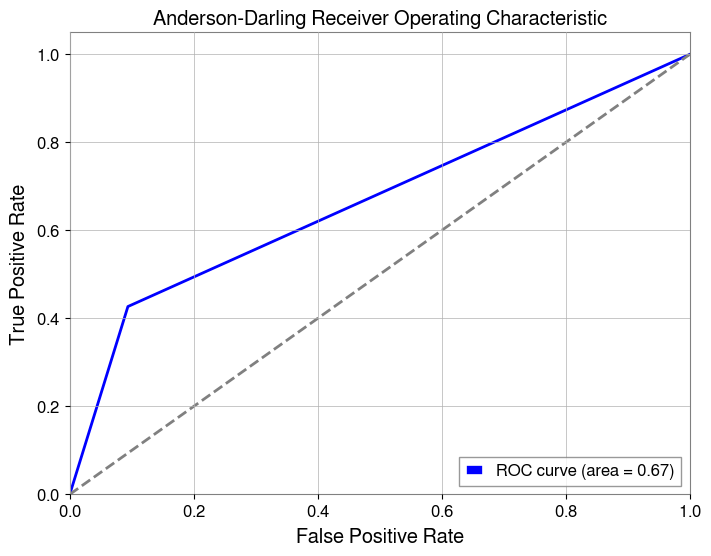

In [36]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df[['ad_statistic','ad_critical_values']], "Anderson")

In [37]:
generate_glitchwise_confusion_matrices(combined_df)

label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          1          5          0          0   
1           1400Ripples         51         50          0          0   
2        Air_Compressor          3         98          0          0   
3                  Blip         94          7          0          0   
4    Blip_Low_Frequency         11         90          0          0   
5                 Chirp          0          6          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering          5         96          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         69          3          0          0   
11  Low_Frequency_Burst          7         91          0          0   
12  Low_Frequency_Lines          8         93          0          0   
13         Paired_Doves         44         57          0          0   
14           Power_Line          2         98          0          0   
15      Repeating_Blips         95          6          0          0   
16      Scattered_Light         19         82          0          0   
17             Scratchy         18         27          0          0   
18                Tomte         42         59          0          0   
19          Violin_Mode         83         18          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         99          2          0          0   
22         clean_signal          0          0         83       1741   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.16667         0.16667           0            1.00000   
1            0.50495         0.50495           0            1.00000   
2            0.02970         0.02970           0            1.00000   
3            0.93069         0.93069           0            1.00000   
4            0.10891         0.10891           0            1.00000   
5            0.00000         0.00000           0            0.00000   
6            1.00000         1.00000           0            1.00000   
7            0.04950         0.04950           0            1.00000   
8            1.00000         1.00000           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           0.95833         0.95833           0            1.00000   
11           0.07143         0.07143           0            1.00000   
12           0.07921         0.07921           0            1.00000   
13           0.43564         0.43564           0            1.00000   
14           0.02000         0.02000           0            1.00000   
15           0.94059         0.94059           0            1.00000   
16           0.18812         0.18812           0            1.00000   
17           0.40000         0.40000           0            1.00000   
18           0.41584         0.41584           0            1.00000   
19           0.82178         0.82178           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.98020         0.98020           0            1.00000   
22           0.95450         0.00000     0.04550            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.28571     0     6     0     0      0.00000    0.00000       0   
1            0.67105     0   101     0     0      0.00000    0.00000       0   
2            0.05769     1   100     0     0      0.00990    0.00990       0   
3            0.96410    14    87     0     0      0.13861    0.13861       0   
4            0.19643     1   100     0     0      0.00990    0.00990       0   
5            0.00000     0     6     0     0      0.00000    0.00000       0   
6            1.00000   101     0     0     0    

In [38]:
generate_glitchwise_confusion_matrices(bp_combined_df)

label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          0          6          0          0   
1           1400Ripples          6         95          0          0   
2        Air_Compressor         12         89          0          0   
3                  Blip         98          3          0          0   
4    Blip_Low_Frequency         19         82          0          0   
5                 Chirp          2          4          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         11         90          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         70          2          0          0   
11  Low_Frequency_Burst          8         90          0          0   
12  Low_Frequency_Lines         10         91          0          0   
13         Paired_Doves         60         41          0          0   
14           Power_Line          3         97          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         24         77          0          0   
17             Scratchy         29         16          0          0   
18                Tomte         60         41          0          0   
19          Violin_Mode         41         60          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         55         46          0          0   
22         clean_signal          0          0        214       1610   

    shapiro_accuracy  shapiro_recall shapiro_fpr shapiro_precision  \
0            0.00000         0.00000           0                 0   
1            0.05941         0.05941           0           1.00000   
2            0.11881         0.11881           0           1.00000   
3            0.97030         0.97030           0           1.00000   
4            0.18812         0.18812           0           1.00000   
5            0.33333         0.33333           0           1.00000   
6            1.00000         1.00000           0           1.00000   
7            0.10891         0.10891           0           1.00000   
8            1.00000         1.00000           0           1.00000   
9            1.00000         1.00000           0           1.00000   
10           0.97222         0.97222           0           1.00000   
11           0.08163         0.08163           0           1.00000   
12           0.09901         0.09901           0           1.00000   
13           0.59406         0.59406           0           1.00000   
14           0.03000         0.03000           0           1.00000   
15           0.97030         0.97030           0           1.00000   
16           0.23762         0.23762           0           1.00000   
17           0.64444         0.64444           0           1.00000   
18           0.59406         0.59406           0           1.00000   
19           0.40594         0.40594           0           1.00000   
20           1.00000         1.00000           0           1.00000   
21           0.54455         0.54455           0           1.00000   
22           0.88268         0.00000     0.11732           0.00000   

   shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0                 0     0     6     0     0      0.00000    0.00000       0   
1           0.11215     1   100     0     0      0.00990    0.00990       0   
2           0.21239     1   100     0     0      0.00990    0.00990       0   
3           0.98492    35    66     0     0      0.34653    0.34653       0   
4           0.31667     3    98     0     0      0.02970    0.02970       0   
5           0.50000     0     6     0     0      0.00000    0.00000       0   
6           1.00000   101     0     0     0      1.00000    1.00000       0   


In [39]:
generate_testwise_confusion_matrix(combined_df)

Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  881   888  83  1741   0.72975                  0.49802 0.04550   
1        KS  397  1372   0  1824   0.61815                  0.22442 0.00000   
2  Anderson  386  1383   0  1824   0.61508                  0.21820 0.00000   

   Precision  F1 Score  
0    0.91390   0.64471  
1    1.00000   0.36657  
2    1.00000   0.35824

In [40]:
generate_testwise_confusion_matrix(bp_combined_df)

Test   TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  836   933  214  1610   0.68077                  0.47258 0.11732   
1        KS  501  1268    2  1822   0.64653                  0.28321 0.00110   
2  Anderson  490  1279    0  1824   0.64403                  0.27699 0.00000   

   Precision  F1 Score  
0    0.79619   0.59312  
1    0.99602   0.44102  
2    1.00000   0.43382

In [41]:
frequency_ranges=[[10, 100], [10, 250], [10, 500], [10, 1000], [250,1000], [500,1000]]

combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
display(generate_testwise_confusion_matrix(combined_df))
for low_freq, high_freq in frequency_ranges:
    print(f"Low Frequency: {low_freq}, High Frequency: {high_freq}")
    combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=low_freq, high_freq=high_freq)
    display(generate_testwise_confusion_matrix(combined_df))
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['shapiro_pvalue'])
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['ks_pvalue'], "KS")
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df[['ad_statistic','ad_critical_values']], "Anderson")

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  881   888  83  1741   0.72975                  0.49802 0.04550   
1        KS  397  1372   0  1824   0.61815                  0.22442 0.00000   
2  Anderson  386  1383   0  1824   0.61508                  0.21820 0.00000   

   Precision  F1 Score  
0    0.91390   0.64471  
1    1.00000   0.36657  
2    1.00000   0.35824

Low Frequency: 10, High Frequency: 100
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP   FN    FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  1768    1  1818     6   0.49374                  0.99943 0.99671   
1        KS  1464  305   907   917   0.66268                  0.82759 0.49726   
2  Anderson  1213  556   294  1530   0.76343                  0.68570 0.16118   

   Precision  F1 Score  
0    0.49303   0.66032  
1    0.61746   0.70725  
2    0.80491   0.74054

Low Frequency: 10, High Frequency: 250
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP    FN    FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  1624   145  1550   274   0.52825                  0.91803   
1        KS   893   876   195  1629   0.70192                  0.50480   
2  Anderson   722  1047    15  1809   0.70443                  0.40814   

      FPR  Precision  F1 Score  
0 0.84978    0.51166   0.65709  
1 0.10691    0.82077   0.62513  
2 0.00822    0.97965   0.57622

Low Frequency: 10, High Frequency: 500
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  1138   631  778  1046   0.60785                  0.64330 0.42654   
1        KS   606  1163   29  1795   0.66824                  0.34257 0.01590   
2  Anderson   565  1204    0  1824   0.66490                  0.31939 0.00000   

   Precision  F1 Score  
0    0.59395   0.61764  
1    0.95433   0.50416  
2    1.00000   0.48415

Low Frequency: 10, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  836   933  214  1610   0.68077                  0.47258 0.11732   
1        KS  501  1268    2  1822   0.64653                  0.28321 0.00110   
2  Anderson  490  1279    0  1824   0.64403                  0.27699 0.00000   

   Precision  F1 Score  
0    0.79619   0.59312  
1    0.99602   0.44102  
2    1.00000   0.43382

Low Frequency: 250, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  622  1147  120  1704   0.64737                  0.35161 0.06579   
1        KS  317  1452    0  1824   0.59588                  0.17920 0.00000   
2  Anderson  308  1461    0  1824   0.59338                  0.17411 0.00000   

   Precision  F1 Score  
0    0.83827   0.49542  
1    1.00000   0.30393  
2    1.00000   0.29658

Low Frequency: 500, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  578  1191  85  1739   0.64487                  0.32674 0.04660   
1        KS  296  1473   0  1824   0.59004                  0.16733 0.00000   
2  Anderson  276  1493   0  1824   0.58447                  0.15602 0.00000   

   Precision  F1 Score  
0    0.87179   0.47533  
1    1.00000   0.28668  
2    1.00000   0.26993

In [42]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
display(generate_glitchwise_confusion_matrices(combined_df))
for low_freq, high_freq in frequency_ranges:
    print(f"Low Frequency: {low_freq}, High Frequency: {high_freq}")
    combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=low_freq, high_freq=high_freq)
    display(generate_glitchwise_confusion_matrices(combined_df))

Input Length:  700


Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          1          5          0          0   
1           1400Ripples         51         50          0          0   
2        Air_Compressor          3         98          0          0   
3                  Blip         94          7          0          0   
4    Blip_Low_Frequency         11         90          0          0   
5                 Chirp          0          6          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering          5         96          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         69          3          0          0   
11  Low_Frequency_Burst          7         91          0          0   
12  Low_Frequency_Lines          8         93          0          0   
13         Paired_Doves         44         57          0          0   
14           Power_Line          2         98          0          0   
15      Repeating_Blips         95          6          0          0   
16      Scattered_Light         19         82          0          0   
17             Scratchy         18         27          0          0   
18                Tomte         42         59          0          0   
19          Violin_Mode         83         18          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         99          2          0          0   
22         clean_signal          0          0         83       1741   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.16667         0.16667           0            1.00000   
1            0.50495         0.50495           0            1.00000   
2            0.02970         0.02970           0            1.00000   
3            0.93069         0.93069           0            1.00000   
4            0.10891         0.10891           0            1.00000   
5            0.00000         0.00000           0            0.00000   
6            1.00000         1.00000           0            1.00000   
7            0.04950         0.04950           0            1.00000   
8            1.00000         1.00000           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           0.95833         0.95833           0            1.00000   
11           0.07143         0.07143           0            1.00000   
12           0.07921         0.07921           0            1.00000   
13           0.43564         0.43564           0            1.00000   
14           0.02000         0.02000           0            1.00000   
15           0.94059         0.94059           0            1.00000   
16           0.18812         0.18812           0            1.00000   
17           0.40000         0.40000           0            1.00000   
18           0.41584         0.41584           0            1.00000   
19           0.82178         0.82178           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.98020         0.98020           0            1.00000   
22           0.95450         0.00000     0.04550            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.28571     0     6     0     0      0.00000    0.00000       0   
1            0.67105     0   101     0     0      0.00000    0.00000       0   
2            0.05769     1   100     0     0      0.00990    0.00990       0   
3            0.96410    14    87     0     0      0.13861    0.13861       0   
4            0.19643     1   100     0     0      0.00990    0.00990       0   
5            0.00000     0     6     0     0      0.00000    0.00000       0   
6            1.00000   101     0     0     0    

Low Frequency: 10, High Frequency: 100
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          6          0          0          0   
1           1400Ripples        101          0          0          0   
2        Air_Compressor        101          0          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency        101          0          0          0   
5                 Chirp          6          0          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering        101          0          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         72          0          0          0   
11  Low_Frequency_Burst         98          0          0          0   
12  Low_Frequency_Lines        101          0          0          0   
13         Paired_Doves        101          0          0          0   
14           Power_Line        100          0          0          0   
15      Repeating_Blips        101          0          0          0   
16      Scattered_Light        100          1          0          0   
17             Scratchy         45          0          0          0   
18                Tomte        101          0          0          0   
19          Violin_Mode        101          0          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle        101          0          0          0   
22         clean_signal          0          0       1818          6   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            1.00000         1.00000           0            1.00000   
1            1.00000         1.00000           0            1.00000   
2            1.00000         1.00000           0            1.00000   
3            1.00000         1.00000           0            1.00000   
4            1.00000         1.00000           0            1.00000   
5            1.00000         1.00000           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            1.00000         1.00000           0            1.00000   
8            1.00000         1.00000           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           1.00000         1.00000           0            1.00000   
11           1.00000         1.00000           0            1.00000   
12           1.00000         1.00000           0            1.00000   
13           1.00000         1.00000           0            1.00000   
14           1.00000         1.00000           0            1.00000   
15           1.00000         1.00000           0            1.00000   
16           0.99010         0.99010           0            1.00000   
17           1.00000         1.00000           0            1.00000   
18           1.00000         1.00000           0            1.00000   
19           1.00000         1.00000           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           1.00000         1.00000           0            1.00000   
22           0.00329         0.00000     0.99671            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            1.00000     5     1     0     0      0.83333    0.83333       0   
1            1.00000    56    45     0     0      0.55446    0.55446       0   
2            1.00000    70    31     0     0      0.69307    0.69307       0   
3            1.00000    83    18     0     0      0.82178    0.82178       0   
4            1.00000    84    17     0     0      0.83168    0.83168       0   
5            1.00000     3     3     0     0      0.50000    0.50000       0   
6            1.00000   101     0     0     0    

Low Frequency: 10, High Frequency: 250
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          6          0          0          0   
1           1400Ripples         82         19          0          0   
2        Air_Compressor         86         15          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency         98          3          0          0   
5                 Chirp          6          0          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         83         18          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         72          0          0          0   
11  Low_Frequency_Burst         77         21          0          0   
12  Low_Frequency_Lines         87         14          0          0   
13         Paired_Doves        101          0          0          0   
14           Power_Line         94          6          0          0   
15      Repeating_Blips        100          1          0          0   
16      Scattered_Light         90         11          0          0   
17             Scratchy         44          1          0          0   
18                Tomte        101          0          0          0   
19          Violin_Mode         88         13          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         78         23          0          0   
22         clean_signal          0          0       1550        274   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            1.00000         1.00000           0            1.00000   
1            0.81188         0.81188           0            1.00000   
2            0.85149         0.85149           0            1.00000   
3            1.00000         1.00000           0            1.00000   
4            0.97030         0.97030           0            1.00000   
5            1.00000         1.00000           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            0.82178         0.82178           0            1.00000   
8            1.00000         1.00000           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           1.00000         1.00000           0            1.00000   
11           0.78571         0.78571           0            1.00000   
12           0.86139         0.86139           0            1.00000   
13           1.00000         1.00000           0            1.00000   
14           0.94000         0.94000           0            1.00000   
15           0.99010         0.99010           0            1.00000   
16           0.89109         0.89109           0            1.00000   
17           0.97778         0.97778           0            1.00000   
18           1.00000         1.00000           0            1.00000   
19           0.87129         0.87129           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.77228         0.77228           0            1.00000   
22           0.15022         0.00000     0.84978            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            1.00000     0     6     0     0      0.00000    0.00000       0   
1            0.89617    14    87     0     0      0.13861    0.13861       0   
2            0.91979    17    84     0     0      0.16832    0.16832       0   
3            1.00000    68    33     0     0      0.67327    0.67327       0   
4            0.98492    28    73     0     0      0.27723    0.27723       0   
5            1.00000     2     4     0     0      0.33333    0.33333       0   
6            1.00000   101     0     0     0    

Low Frequency: 10, High Frequency: 500
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          2          4          0          0   
1           1400Ripples         21         80          0          0   
2        Air_Compressor         30         71          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency         64         37          0          0   
5                 Chirp          4          2          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         30         71          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         71          1          0          0   
11  Low_Frequency_Burst         34         64          0          0   
12  Low_Frequency_Lines         38         63          0          0   
13         Paired_Doves         80         21          0          0   
14           Power_Line         44         56          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         59         42          0          0   
17             Scratchy         38          7          0          0   
18                Tomte         91         10          0          0   
19          Violin_Mode         54         47          0          0   
20       Wandering_Line          8          1          0          0   
21              Whistle         50         51          0          0   
22         clean_signal          0          0        778       1046   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.33333         0.33333           0            1.00000   
1            0.20792         0.20792           0            1.00000   
2            0.29703         0.29703           0            1.00000   
3            1.00000         1.00000           0            1.00000   
4            0.63366         0.63366           0            1.00000   
5            0.66667         0.66667           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            0.29703         0.29703           0            1.00000   
8            1.00000         1.00000           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           0.98611         0.98611           0            1.00000   
11           0.34694         0.34694           0            1.00000   
12           0.37624         0.37624           0            1.00000   
13           0.79208         0.79208           0            1.00000   
14           0.44000         0.44000           0            1.00000   
15           0.97030         0.97030           0            1.00000   
16           0.58416         0.58416           0            1.00000   
17           0.84444         0.84444           0            1.00000   
18           0.90099         0.90099           0            1.00000   
19           0.53465         0.53465           0            1.00000   
20           0.88889         0.88889           0            1.00000   
21           0.49505         0.49505           0            1.00000   
22           0.57346         0.00000     0.42654            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.50000     0     6     0     0      0.00000    0.00000       0   
1            0.34426     1   100     0     0      0.00990    0.00990       0   
2            0.45802     3    98     0     0      0.02970    0.02970       0   
3            1.00000    48    53     0     0      0.47525    0.47525       0   
4            0.77576     8    93     0     0      0.07921    0.07921       0   
5            0.80000     0     6     0     0      0.00000    0.00000       0   
6            1.00000   101     0     0     0    

Low Frequency: 10, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          0          6          0          0   
1           1400Ripples          6         95          0          0   
2        Air_Compressor         12         89          0          0   
3                  Blip         98          3          0          0   
4    Blip_Low_Frequency         19         82          0          0   
5                 Chirp          2          4          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         11         90          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         70          2          0          0   
11  Low_Frequency_Burst          8         90          0          0   
12  Low_Frequency_Lines         10         91          0          0   
13         Paired_Doves         60         41          0          0   
14           Power_Line          3         97          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         24         77          0          0   
17             Scratchy         29         16          0          0   
18                Tomte         60         41          0          0   
19          Violin_Mode         41         60          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         55         46          0          0   
22         clean_signal          0          0        214       1610   

    shapiro_accuracy  shapiro_recall shapiro_fpr shapiro_precision  \
0            0.00000         0.00000           0                 0   
1            0.05941         0.05941           0           1.00000   
2            0.11881         0.11881           0           1.00000   
3            0.97030         0.97030           0           1.00000   
4            0.18812         0.18812           0           1.00000   
5            0.33333         0.33333           0           1.00000   
6            1.00000         1.00000           0           1.00000   
7            0.10891         0.10891           0           1.00000   
8            1.00000         1.00000           0           1.00000   
9            1.00000         1.00000           0           1.00000   
10           0.97222         0.97222           0           1.00000   
11           0.08163         0.08163           0           1.00000   
12           0.09901         0.09901           0           1.00000   
13           0.59406         0.59406           0           1.00000   
14           0.03000         0.03000           0           1.00000   
15           0.97030         0.97030           0           1.00000   
16           0.23762         0.23762           0           1.00000   
17           0.64444         0.64444           0           1.00000   
18           0.59406         0.59406           0           1.00000   
19           0.40594         0.40594           0           1.00000   
20           1.00000         1.00000           0           1.00000   
21           0.54455         0.54455           0           1.00000   
22           0.88268         0.00000     0.11732           0.00000   

   shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0                 0     0     6     0     0      0.00000    0.00000       0   
1           0.11215     1   100     0     0      0.00990    0.00990       0   
2           0.21239     1   100     0     0      0.00990    0.00990       0   
3           0.98492    35    66     0     0      0.34653    0.34653       0   
4           0.31667     3    98     0     0      0.02970    0.02970       0   
5           0.50000     0     6     0     0      0.00000    0.00000       0   
6           1.00000   101     0     0     0      1.00000    1.00000       0   


Low Frequency: 250, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          1          5          0          0   
1           1400Ripples          6         95          0          0   
2        Air_Compressor          4         97          0          0   
3                  Blip         77         24          0          0   
4    Blip_Low_Frequency          9         92          0          0   
5                 Chirp          0          6          0          0   
6        Extremely_Loud        100          1          0          0   
7       Fast_Scattering          6         95          0          0   
8                 Helix         16          5          0          0   
9              Koi_Fish         97          2          0          0   
10     Light_Modulation         62         10          0          0   
11  Low_Frequency_Burst          5         93          0          0   
12  Low_Frequency_Lines          4         97          0          0   
13         Paired_Doves         19         82          0          0   
14           Power_Line          1         99          0          0   
15      Repeating_Blips         83         18          0          0   
16      Scattered_Light          5         96          0          0   
17             Scratchy          9         36          0          0   
18                Tomte          2         99          0          0   
19          Violin_Mode         43         58          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         64         37          0          0   
22         clean_signal          0          0        120       1704   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.16667         0.16667           0            1.00000   
1            0.05941         0.05941           0            1.00000   
2            0.03960         0.03960           0            1.00000   
3            0.76238         0.76238           0            1.00000   
4            0.08911         0.08911           0            1.00000   
5            0.00000         0.00000           0            0.00000   
6            0.99010         0.99010           0            1.00000   
7            0.05941         0.05941           0            1.00000   
8            0.76190         0.76190           0            1.00000   
9            0.97980         0.97980           0            1.00000   
10           0.86111         0.86111           0            1.00000   
11           0.05102         0.05102           0            1.00000   
12           0.03960         0.03960           0            1.00000   
13           0.18812         0.18812           0            1.00000   
14           0.01000         0.01000           0            1.00000   
15           0.82178         0.82178           0            1.00000   
16           0.04950         0.04950           0            1.00000   
17           0.20000         0.20000           0            1.00000   
18           0.01980         0.01980           0            1.00000   
19           0.42574         0.42574           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.63366         0.63366           0            1.00000   
22           0.93421         0.00000     0.06579            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.28571     0     6     0     0      0.00000    0.00000       0   
1            0.11215     0   101     0     0      0.00000    0.00000       0   
2            0.07619     1   100     0     0      0.00990    0.00990       0   
3            0.86517    19    82     0     0      0.18812    0.18812       0   
4            0.16364     0   101     0     0      0.00000    0.00000       0   
5            0.00000     0     6     0     0      0.00000    0.00000       0   
6            0.99502   100     1     0     0    

Low Frequency: 500, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          1          5          0          0   
1           1400Ripples         14         87          0          0   
2        Air_Compressor          3         98          0          0   
3                  Blip         48         53          0          0   
4    Blip_Low_Frequency         13         88          0          0   
5                 Chirp          0          6          0          0   
6        Extremely_Loud        100          1          0          0   
7       Fast_Scattering          5         96          0          0   
8                 Helix         13          8          0          0   
9              Koi_Fish         83         16          0          0   
10     Light_Modulation         52         20          0          0   
11  Low_Frequency_Burst         10         88          0          0   
12  Low_Frequency_Lines          7         94          0          0   
13         Paired_Doves         19         82          0          0   
14           Power_Line          2         98          0          0   
15      Repeating_Blips         57         44          0          0   
16      Scattered_Light          4         97          0          0   
17             Scratchy          8         37          0          0   
18                Tomte          6         95          0          0   
19          Violin_Mode         56         45          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         68         33          0          0   
22         clean_signal          0          0         85       1739   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.16667         0.16667           0            1.00000   
1            0.13861         0.13861           0            1.00000   
2            0.02970         0.02970           0            1.00000   
3            0.47525         0.47525           0            1.00000   
4            0.12871         0.12871           0            1.00000   
5            0.00000         0.00000           0            0.00000   
6            0.99010         0.99010           0            1.00000   
7            0.04950         0.04950           0            1.00000   
8            0.61905         0.61905           0            1.00000   
9            0.83838         0.83838           0            1.00000   
10           0.72222         0.72222           0            1.00000   
11           0.10204         0.10204           0            1.00000   
12           0.06931         0.06931           0            1.00000   
13           0.18812         0.18812           0            1.00000   
14           0.02000         0.02000           0            1.00000   
15           0.56436         0.56436           0            1.00000   
16           0.03960         0.03960           0            1.00000   
17           0.17778         0.17778           0            1.00000   
18           0.05941         0.05941           0            1.00000   
19           0.55446         0.55446           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.67327         0.67327           0            1.00000   
22           0.95340         0.00000     0.04660            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.28571     0     6     0     0      0.00000    0.00000       0   
1            0.24348    10    91     0     0      0.09901    0.09901       0   
2            0.05769     2    99     0     0      0.01980    0.01980       0   
3            0.64430    18    83     0     0      0.17822    0.17822       0   
4            0.22807     2    99     0     0      0.01980    0.01980       0   
5            0.00000     0     6     0     0      0.00000    0.00000       0   
6            0.99502    95     6     0     0    

In [43]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=1000, high_freq=1100)
display(generate_glitchwise_confusion_matrices(combined_df))

Input Length:  700


Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          5          1          0          0   
1           1400Ripples         58         43          0          0   
2        Air_Compressor         54         47          0          0   
3                  Blip         61         40          0          0   
4    Blip_Low_Frequency         60         41          0          0   
5                 Chirp          3          3          0          0   
6        Extremely_Loud         99          2          0          0   
7       Fast_Scattering         61         40          0          0   
8                 Helix          9         12          0          0   
9              Koi_Fish         73         26          0          0   
10     Light_Modulation         52         20          0          0   
11  Low_Frequency_Burst         59         39          0          0   
12  Low_Frequency_Lines         53         48          0          0   
13         Paired_Doves         43         58          0          0   
14           Power_Line         45         55          0          0   
15      Repeating_Blips         61         40          0          0   
16      Scattered_Light         56         45          0          0   
17             Scratchy         26         19          0          0   
18                Tomte         53         48          0          0   
19          Violin_Mode         88         13          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         93          8          0          0   
22         clean_signal          0          0        977        847   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.83333         0.83333           0            1.00000   
1            0.57426         0.57426           0            1.00000   
2            0.53465         0.53465           0            1.00000   
3            0.60396         0.60396           0            1.00000   
4            0.59406         0.59406           0            1.00000   
5            0.50000         0.50000           0            1.00000   
6            0.98020         0.98020           0            1.00000   
7            0.60396         0.60396           0            1.00000   
8            0.42857         0.42857           0            1.00000   
9            0.73737         0.73737           0            1.00000   
10           0.72222         0.72222           0            1.00000   
11           0.60204         0.60204           0            1.00000   
12           0.52475         0.52475           0            1.00000   
13           0.42574         0.42574           0            1.00000   
14           0.45000         0.45000           0            1.00000   
15           0.60396         0.60396           0            1.00000   
16           0.55446         0.55446           0            1.00000   
17           0.57778         0.57778           0            1.00000   
18           0.52475         0.52475           0            1.00000   
19           0.87129         0.87129           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.92079         0.92079           0            1.00000   
22           0.46436         0.00000     0.53564            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.90909     1     5     0     0      0.16667    0.16667       0   
1            0.72956     5    96     0     0      0.04950    0.04950       0   
2            0.69677    12    89     0     0      0.11881    0.11881       0   
3            0.75309     9    92     0     0      0.08911    0.08911       0   
4            0.74534     2    99     0     0      0.01980    0.01980       0   
5            0.66667     0     6     0     0      0.00000    0.00000       0   
6            0.99000    91    10     0     0    

Time elapsed for q-transform: 0.42 seconds


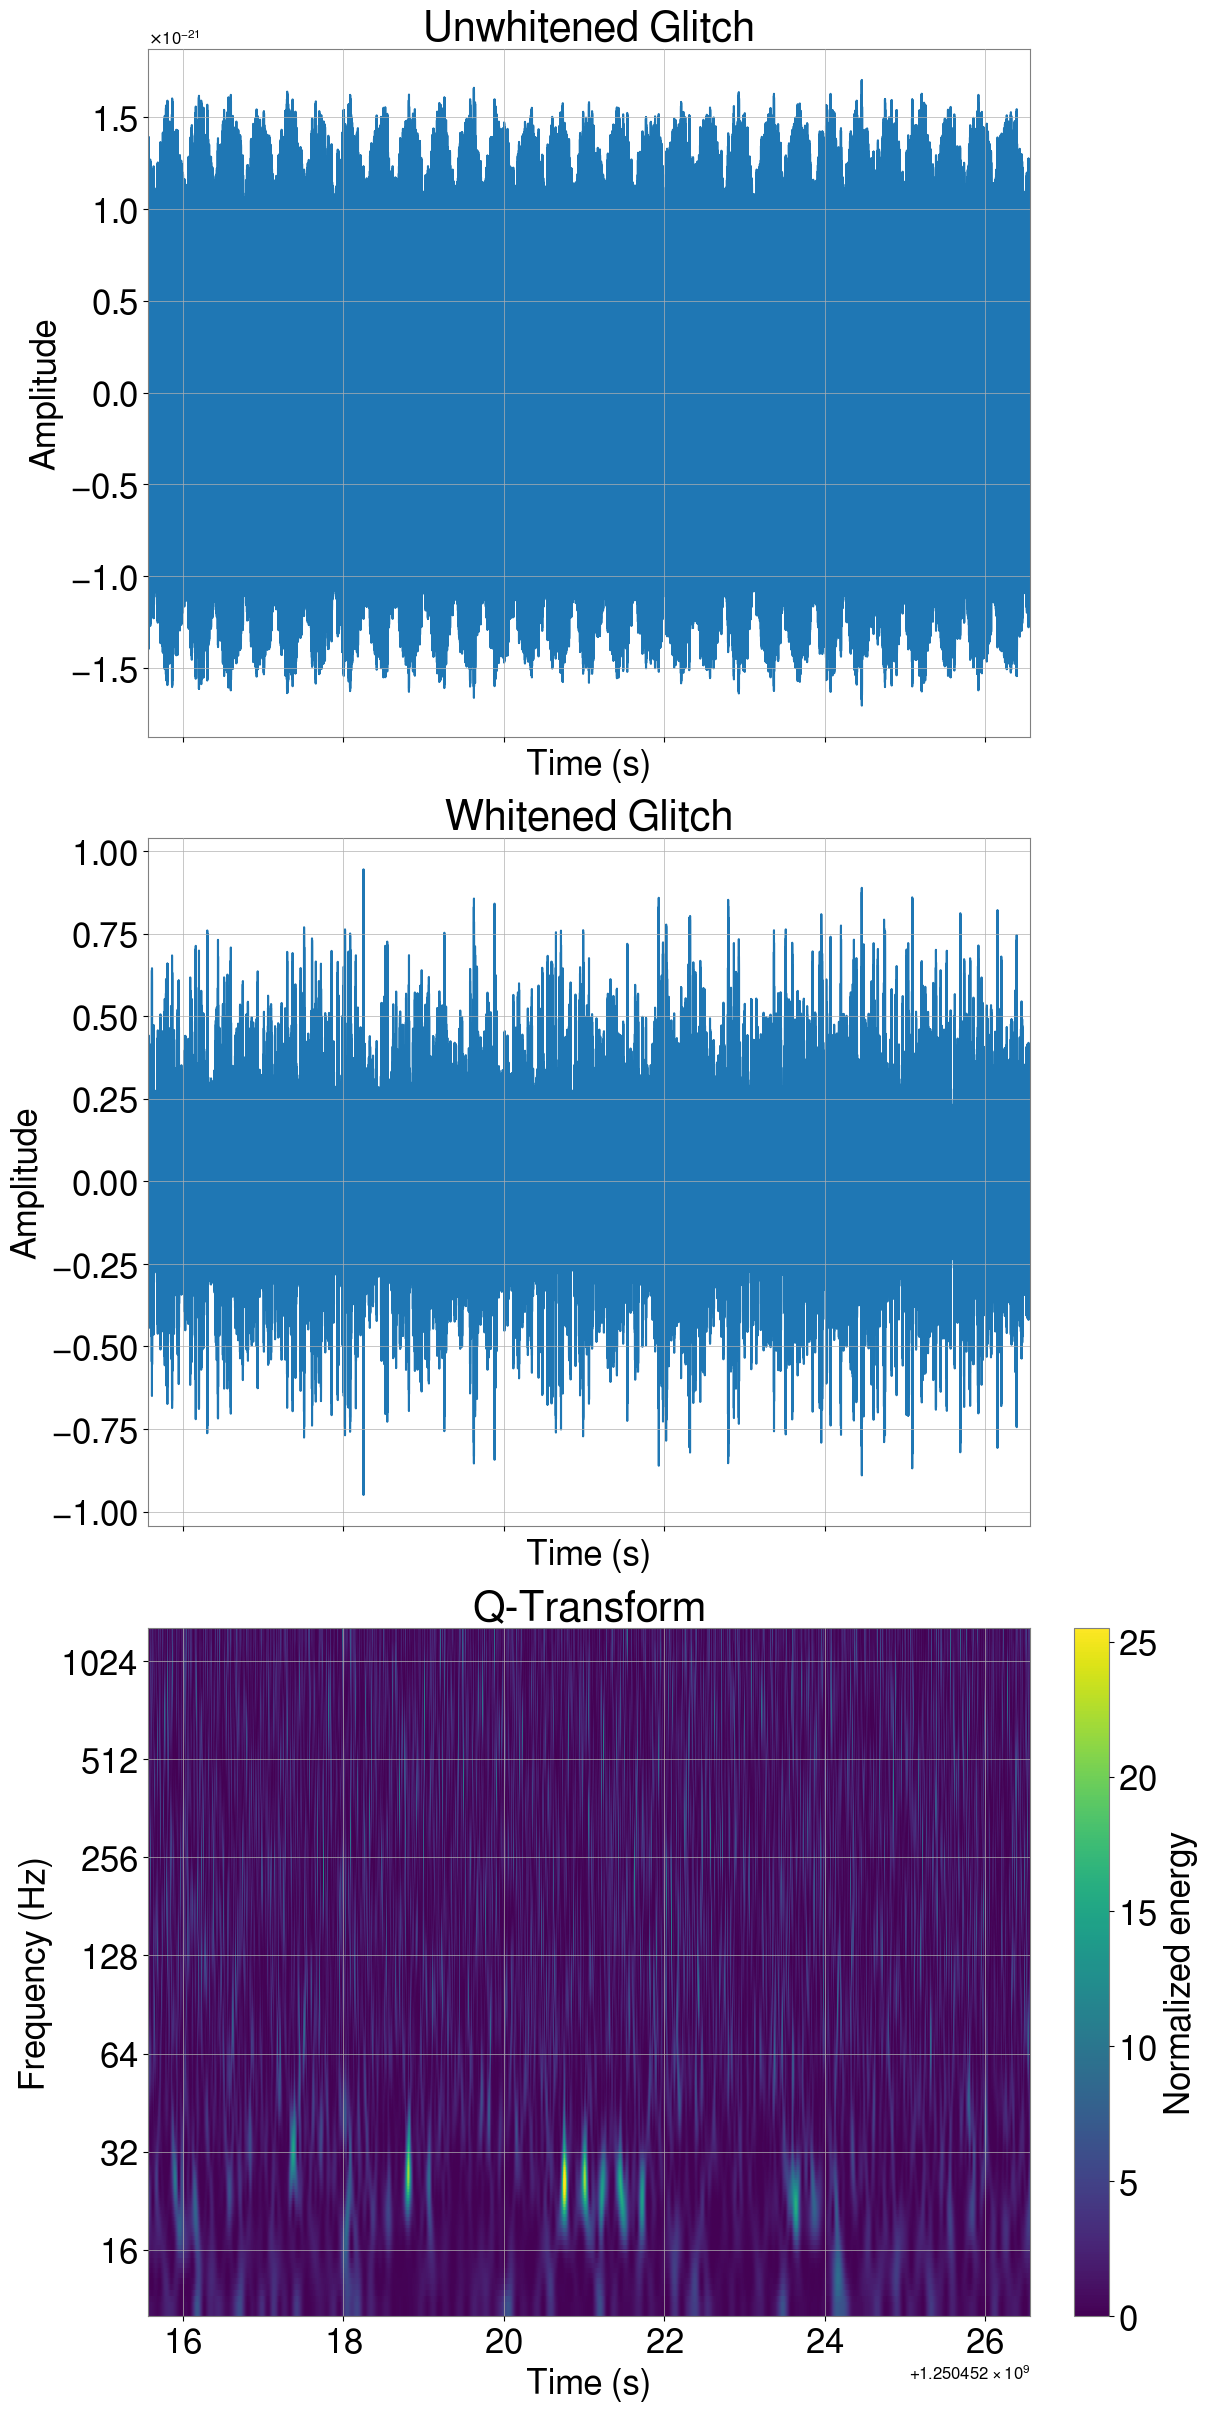

In [44]:
statistical_testing.display_sample_plots(combined_df[combined_df['label'] == 'Scattered_Light'].sample(1).iloc[0])

# Experimenting with the Fractal Dimension

The fractal dimension is another way for us to visualize and characterize our data. FD characterizes the self similarity of a set and provides a measure of complexity of the signal in terms of signal processing. Basically, it tells us how complex a shape is, which in this case would be the shape of the time series signal. If we were to use this in the context of time series signals, it would be as a **Variation over Time** telling us how complex the signal is. Glitches cause this FD value to change.

For this we use the VAR method. (Referenced from LIGO repositories)

In [20]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, observation_tw=5, n_samples=2000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [21]:
combined_df.shape

(3593, 17)

In [22]:
# Tomte
example = combined_df.loc[combined_df['label'] == 'Tomte'].iloc[0]
example_ts = statistical_testing.get_sample_glitch_from_filepath(example["timeseries_file_location"])[1]

In [23]:
# Clean Signal
example2 = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[1]

example_ts2 = TimeSeries.read(example2["timeseries_file_location"])
example_ts2 = example_ts2.whiten(4,2)
example_ts2 = example_ts2[int(4096):int(8192)]

asd = example_ts2.asd()

In [24]:
# Scattered Light
example3 = combined_df.loc[combined_df['label'] == 'Scattered_Light'].iloc[0]
example_ts3 = statistical_testing.get_sample_glitch_from_filepath(example3["timeseries_file_location"])[1]

In [25]:
example["timeseries_file_location"]

'./timeseries_data/sample_L1_1248235640.34_white10.h5'

In [26]:
example_ts.shape

(4096,)

In [27]:
np.arange(0, 4096//(2*64))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31])

In [28]:
import numba

### What's happening here (My understanding of it)

F_k contains all the fractional dimensions being calculated for the given TimeSeries signal given the decimate value.

To calculate F_k, the outer loop takes values from 1 to half the length of the signal times the deimate, while the inner loop goes from the value of the outer loop to the end of the signal minus the outer loop value. At each iteration of the inner loop a window  of size [k-l, k-l+1] goes along the signal and calculates the absolute value of the difference between the minimum and maximum amplitude values, the mean of which us the A_var values. With each outer iteration the size of this window increases gradually until it goes up to the whole length of the signal.

Second version of FD code (the correct implementation) 

In [29]:
@numba.njit("f4[:](f4[:,:], i8, i8)", parallel=True)
def faster_compute_fractals_var(fs, dec, step):
    FDs = np.empty(shape=fs.shape[0], dtype=np.float32)
    N = fs.shape[1]
    for ii in numba.prange(fs.shape[0]):
        f = fs[ii]
        k_n = np.arange(1, N//(2*dec), step, np.int64)
        n_max = len(k_n)
        V_i = np.empty(shape=(n_max), dtype=np.float32)

        ub = np.empty(shape=(N-2*k_n[0],2), dtype=np.float32) # current iteration
        for i in range(0, N-2*k_n[0]):
            ub[i,0] = np.max(f[i:i+2*k_n[0]+1])
            ub[i,1] = np.min(f[i:i+2*k_n[0]+1])
        V_i[0] = np.mean(ub[:,0]-ub[:,1])

        for n in range(1,n_max):
            d = k_n[n] - k_n[n-1]
            for i in range(0, N-2*k_n[n]):
                ub[i,0] = max(ub[i,0], ub[i+2*d,0])
                ub[i,1] = min(ub[i,1], ub[i+2*d,1])
            V_i[n] = np.mean(ub[:N-2*k_n[n],0]-ub[:N-2*k_n[n],1])

        X = np.log(k_n)
        X_m = X - np.mean(X)
        Y = np.log(V_i)
        Y_m = Y - np.mean(Y)
        FDs[ii] = 2 - np.sum((X_m)*(Y_m))/np.sum((X_m)**2)
    return FDs


In [30]:
def segmentize(data, seg_length, overlap):
    """
    Segment the data into overlapping segments.
    """

    data_strides = data.strides

    num_segs = int((data.shape[1] - overlap)/(seg_length - overlap))
    seg_shape = (data.shape[0], num_segs, seg_length)

    seg_strides = (data_strides[0], data_strides[1]*(seg_length - overlap), data_strides[1])

    segs = np.lib.stride_tricks.as_strided(data, shape=seg_shape, strides=seg_strides)

    return segs
    

In [31]:
# eg_ts2d_chunks = np.split(example_ts.value, 64)

In [32]:
# len(eg_ts2d_chunks)

In [33]:
# eg_fd1 = []
# for chunk in eg_ts2d_chunks:
#     eg_fd1.append(faster_compute_fractals_var(np.array(chunk.reshape(1,-1).astype(np.float32)), dec=8, step=2))

In [34]:
eg_ts2d = example_ts.value.reshape(1,-1).astype(np.float32)

In [35]:
eg_ts2d.shape

(1, 4096)

In [36]:
eg_ts2d_segmented = segmentize(eg_ts2d, 64, 32)

In [37]:
eg_ts2d_segmented.shape

(1, 127, 64)

In [38]:
points_per_seg = eg_ts2d_segmented.shape[1]
eg_ts2d_segmented = eg_ts2d_segmented.reshape(eg_ts2d_segmented.shape[0]*eg_ts2d_segmented.shape[1], eg_ts2d_segmented.shape[2])

In [39]:
eg_ts2d_segmented.shape

(127, 64)

In [40]:
eg_fd1 = faster_compute_fractals_var(eg_ts2d_segmented, dec=2, step=2)

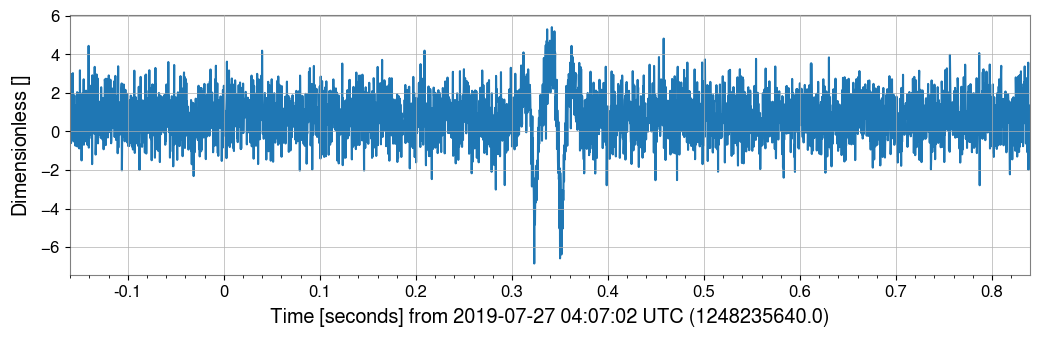

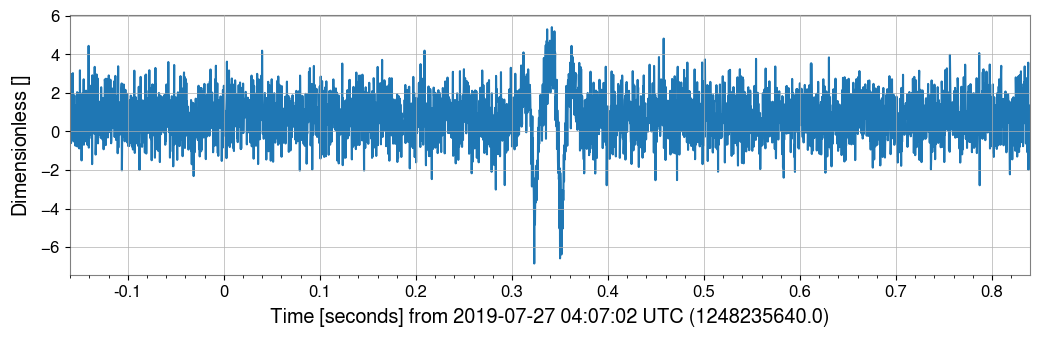

In [41]:
example_ts.plot()

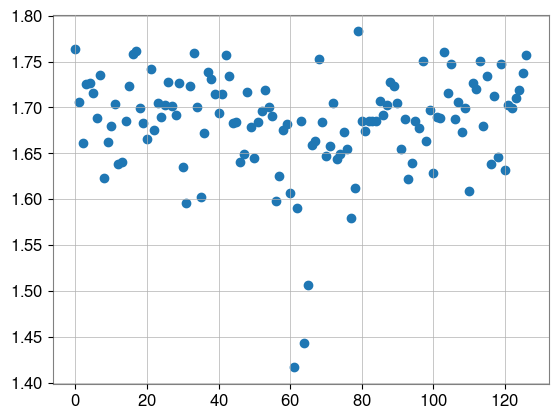

In [42]:
# Tomte
plt.plot(eg_fd1, 'o')

In [43]:
eg_ts2d2 = example_ts2.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented2 = segmentize(eg_ts2d2, 64, 32)
points_per_seg = eg_ts2d_segmented2.shape[1]
eg_ts2d_segmented2 = eg_ts2d_segmented2.reshape(eg_ts2d_segmented2.shape[0]*eg_ts2d_segmented2.shape[1], eg_ts2d_segmented2.shape[2])
eg_fd2 = faster_compute_fractals_var(eg_ts2d_segmented2, dec=2, step=2)

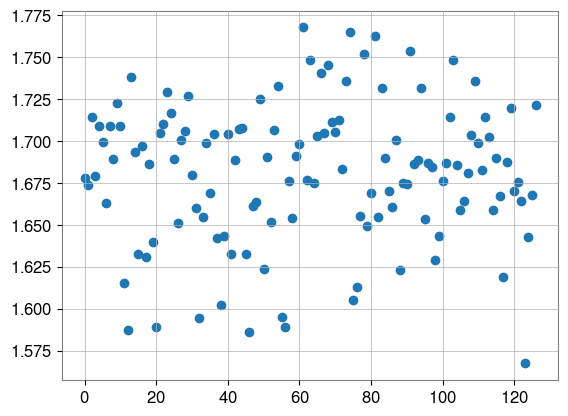

In [44]:
#Clean Signal
plt.plot(eg_fd2, 'o')

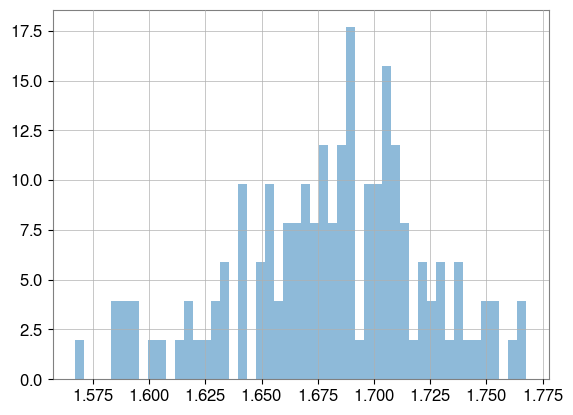

In [45]:
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.show()

In [46]:
eg_ts2d3 = example_ts3.value.reshape(1,-1).astype(np.float32)

In [47]:
eg_ts2d3 = example_ts3.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented3 = segmentize(eg_ts2d3, 64, 32)
points_per_seg = eg_ts2d_segmented3.shape[1]
eg_ts2d_segmented3 = eg_ts2d_segmented3.reshape(eg_ts2d_segmented3.shape[0]*eg_ts2d_segmented3.shape[1], eg_ts2d_segmented3.shape[2])
eg_fd3 = faster_compute_fractals_var(eg_ts2d_segmented3, dec=2, step=2)

In [48]:
#Scattered Light
plt.plot(eg_fd3, 'o')

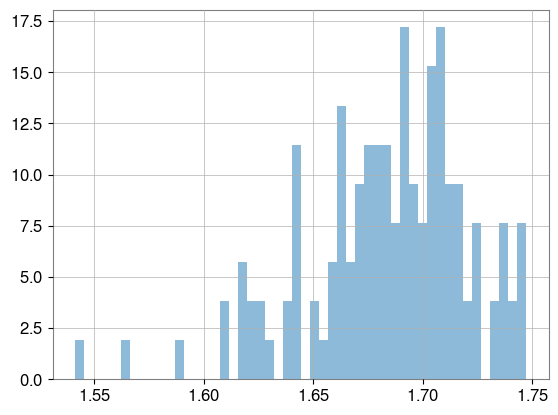

In [49]:
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.show()

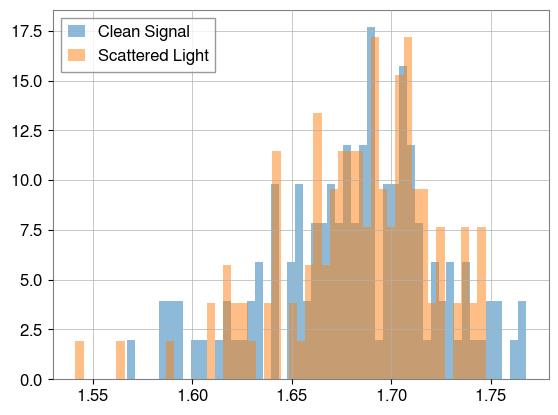

In [50]:
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Clean Signal', density=True)
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.legend()
plt.show()

In [51]:
example4 = combined_df.loc[combined_df['label'] == 'Extremely_Loud'].iloc[1]
example_ts4 = statistical_testing.get_sample_glitch_from_filepath(example4["timeseries_file_location"])[1]

In [52]:
eg_ts2d4 = example_ts4.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented4 = segmentize(eg_ts2d4, 64, 32)
points_per_seg = eg_ts2d_segmented4.shape[1]
eg_ts2d_segmented4 = eg_ts2d_segmented4.reshape(eg_ts2d_segmented4.shape[0]*eg_ts2d_segmented4.shape[1], eg_ts2d_segmented4.shape[2])
eg_fd4 = faster_compute_fractals_var(eg_ts2d_segmented4, dec=2, step=2)

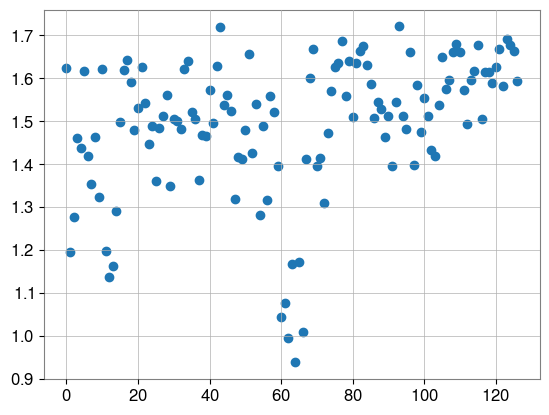

In [53]:
# Extremely Loud
plt.plot(eg_fd4, 'o')

In [54]:
# Clean Signal
example5 = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[1]

example_ts5 = TimeSeries.read(example5["timeseries_file_location"])
example_ts5 = example_ts5.whiten(4,2)
example_ts5 = example_ts5[int(4096):int(8192)]

asd = example_ts5.asd()

In [55]:
eg_ts2d5 = example_ts2.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented5 = segmentize(eg_ts2d5, 64, 32)
points_per_seg = eg_ts2d_segmented5.shape[1]
eg_ts2d_segmented5 = eg_ts2d_segmented5.reshape(eg_ts2d_segmented5.shape[0]*eg_ts2d_segmented5.shape[1], eg_ts2d_segmented5.shape[2])
eg_fd5 = faster_compute_fractals_var(eg_ts2d_segmented5, dec=2, step=2)

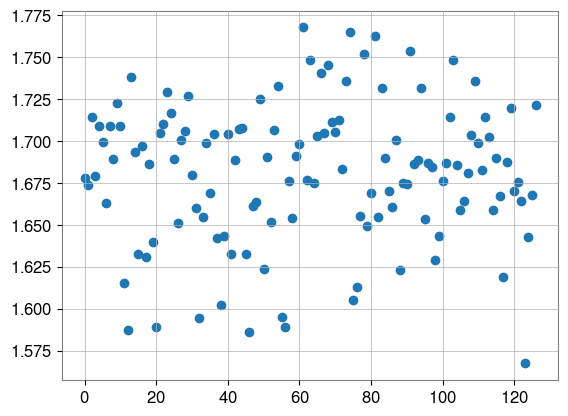

In [56]:
plt.plot(eg_fd5, 'o')

In [57]:
# Blip example
example6 = combined_df.loc[combined_df['label'] == 'Blip'].iloc[5]
example_ts6 = statistical_testing.get_sample_glitch_from_filepath(example6["timeseries_file_location"])[1]

eg_ts2d6 = example_ts6.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented6 = segmentize(eg_ts2d6, 64, 32)
points_per_seg6 = eg_ts2d_segmented6.shape[1]
eg_ts2d_segmented6 = eg_ts2d_segmented6.reshape(eg_ts2d_segmented6.shape[0]*eg_ts2d_segmented6.shape[1], eg_ts2d_segmented6.shape[2])
eg_fd6 = faster_compute_fractals_var(eg_ts2d_segmented6, dec=2, step=2)

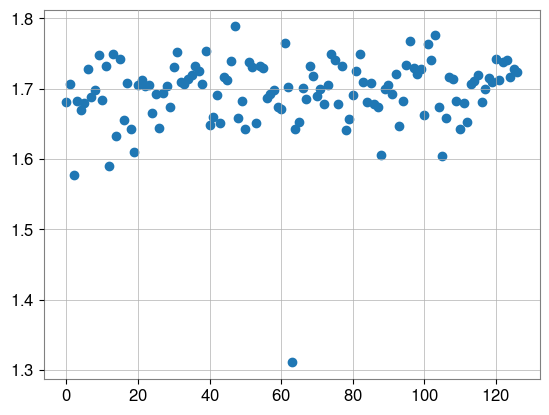

In [58]:
plt.plot(eg_fd6, 'o')

In [59]:
# 1080Lines example
example7 = combined_df.loc[combined_df['label'] == '1080Lines'].iloc[2]
example_ts7 = statistical_testing.get_sample_glitch_from_filepath(example7["timeseries_file_location"])[1]

eg_ts2d7 = example_ts6.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented7 = segmentize(eg_ts2d7, 64, 32)
points_per_seg7 = eg_ts2d_segmented7.shape[1]
eg_ts2d_segmented7 = eg_ts2d_segmented7.reshape(eg_ts2d_segmented7.shape[0]*eg_ts2d_segmented7.shape[1], eg_ts2d_segmented7.shape[2])
eg_fd7 = faster_compute_fractals_var(eg_ts2d_segmented7, dec=2, step=2)

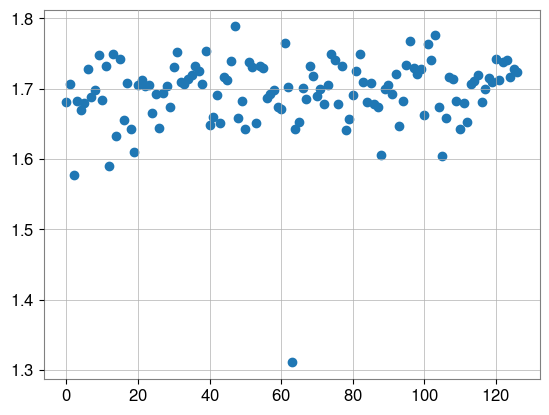

In [60]:
plt.plot(eg_fd7, 'o')

In [61]:
# Chirp example
example8 = combined_df.loc[combined_df['label'] == 'Chirp'].iloc[1]
example_ts8 = statistical_testing.get_sample_glitch_from_filepath(example8["timeseries_file_location"])[1]

eg_ts2d8 = example_ts8.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented8 = segmentize(eg_ts2d8, 64, 32)
points_per_seg8 = eg_ts2d_segmented8.shape[1]
eg_ts2d_segmented8 = eg_ts2d_segmented8.reshape(eg_ts2d_segmented8.shape[0]*eg_ts2d_segmented8.shape[1], eg_ts2d_segmented8.shape[2])
eg_fd8 = faster_compute_fractals_var(eg_ts2d_segmented8, dec=2, step=2)

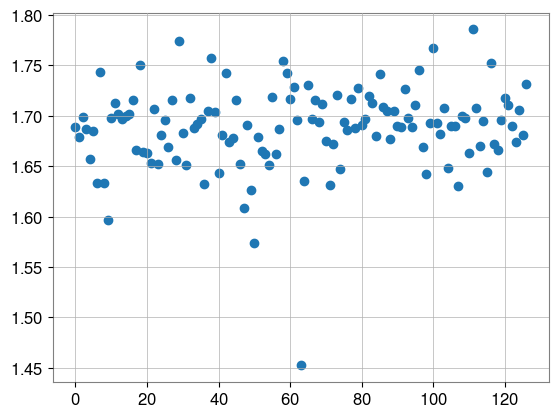

In [62]:
plt.plot(eg_fd8, 'o')

In [63]:
# Koi_Fish example
example9 = combined_df.loc[combined_df['label'] == 'Koi_Fish'].iloc[1]
example_ts9 = statistical_testing.get_sample_glitch_from_filepath(example9["timeseries_file_location"])[1]

eg_ts2d9 = example_ts9.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented9 = segmentize(eg_ts2d9, 64, 32)
points_per_seg9 = eg_ts2d_segmented9.shape[1]
eg_ts2d_segmented9 = eg_ts2d_segmented9.reshape(eg_ts2d_segmented9.shape[0]*eg_ts2d_segmented9.shape[1], eg_ts2d_segmented9.shape[2])
eg_fd9 = faster_compute_fractals_var(eg_ts2d_segmented9, dec=2, step=2)

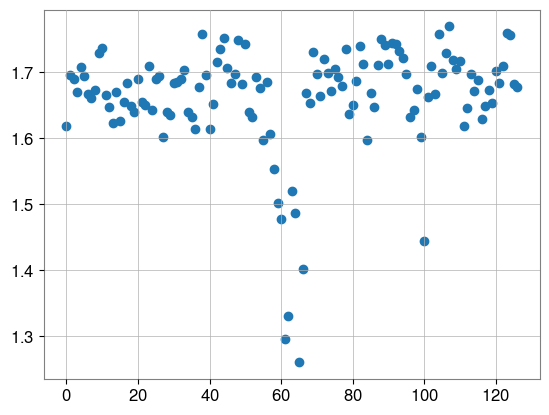

In [64]:
plt.plot(eg_fd9, 'o')

In [65]:
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Clean Signal', density=True)
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.hist(eg_fd1, bins=50, alpha=0.5, label='Tomte', density=True)
plt.legend()
plt.show()

### Studying the FFTs of the signals

In [69]:
from scipy import signal

eg_fft = example_ts.fft()
eg_fft2 = example_ts2.fft()
eg_fft3 = example_ts3.fft()

f1, t1, Zxx1 = signal.stft(example_ts, fs=4096, nperseg=32, noverlap=16)
f2, t2, Zxx2 = signal.stft(example_ts2, fs=4096, nperseg=32, noverlap=16)
f3, t3, Zxx3 = signal.stft(example_ts3, fs=4096, nperseg=32, noverlap=16)

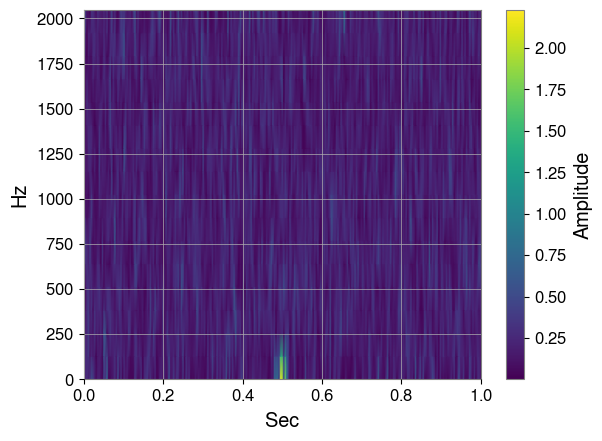

In [70]:
# Tomte
plt.pcolormesh(t1, f1, np.abs(Zxx1), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

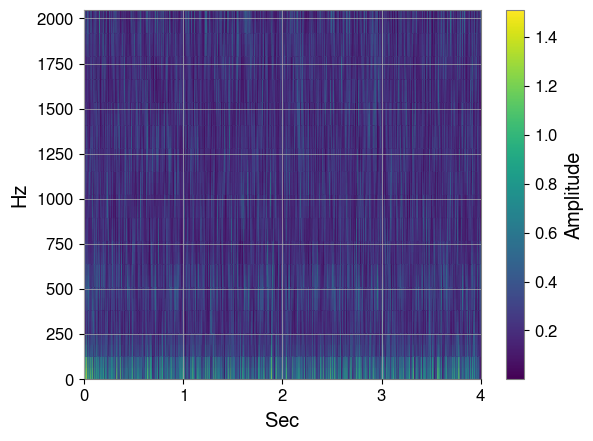

In [71]:
# Clean Signal
plt.pcolormesh(t2, f2, np.abs(Zxx2), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

In [72]:
# Scattered Light
plt.pcolormesh(t3, f3, np.abs(Zxx3), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

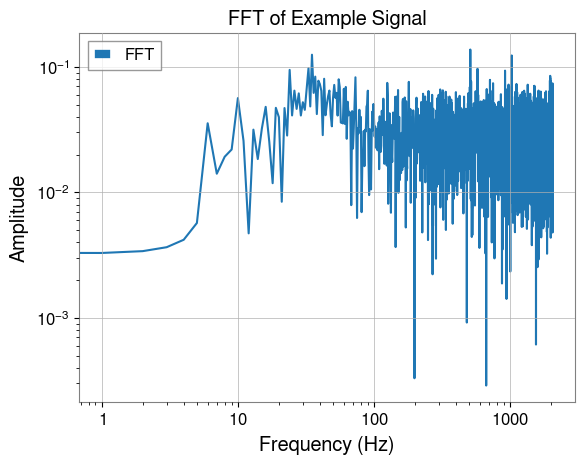

In [73]:
# Tomte
plt.plot(eg_fft.frequencies, np.abs(eg_fft.value), label="FFT")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

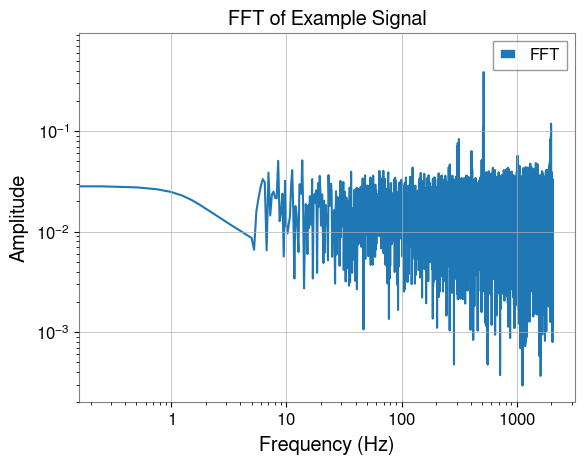

In [74]:
# Clean Data
plt.plot(eg_fft2.frequencies, np.abs(eg_fft2.value), label="FFT")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

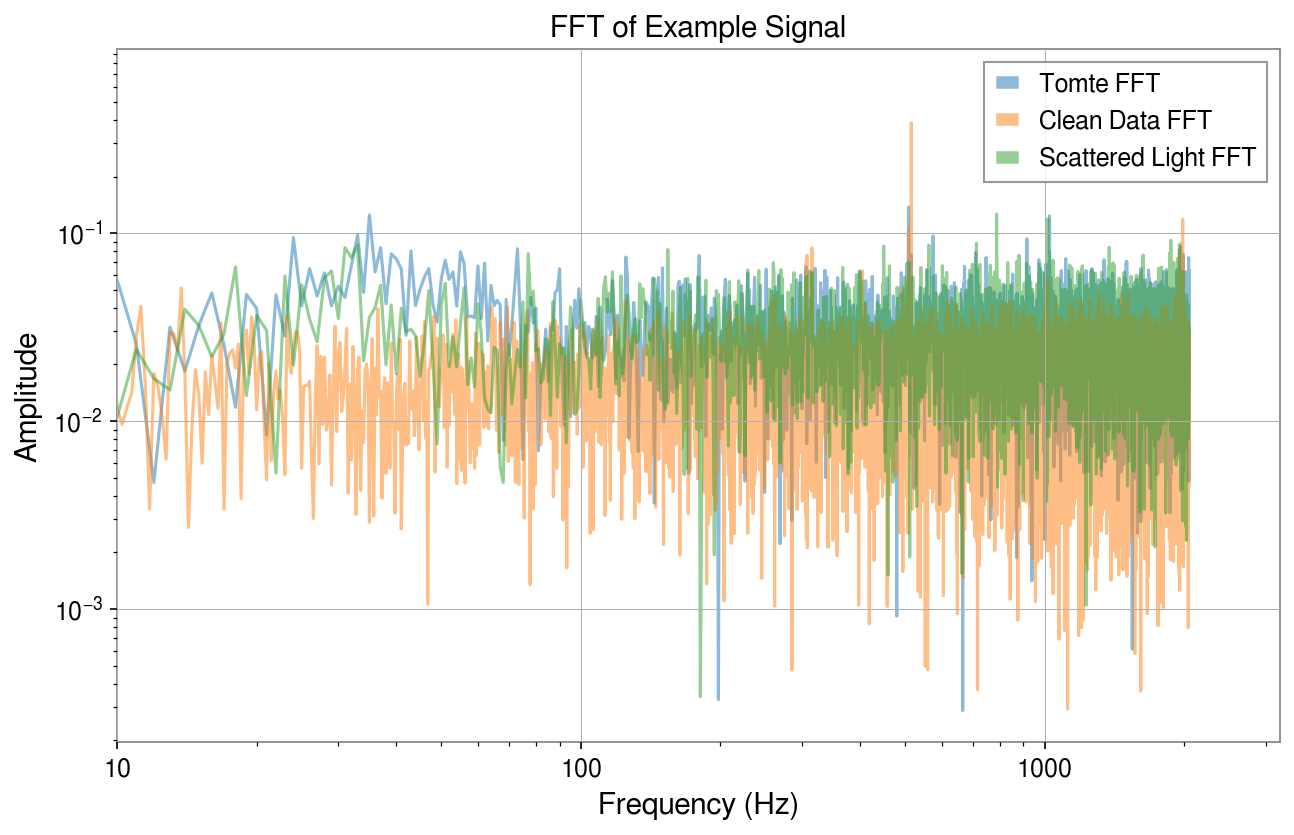

In [75]:
# Scattered Light
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(eg_fft.frequencies, np.abs(eg_fft.value), label="Tomte FFT", alpha=0.5)
plt.plot(eg_fft2.frequencies, np.abs(eg_fft2.value), label="Clean Data FFT", alpha=0.5)
plt.plot(eg_fft3.frequencies, np.abs(eg_fft3.value), label="Scattered Light FFT", alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

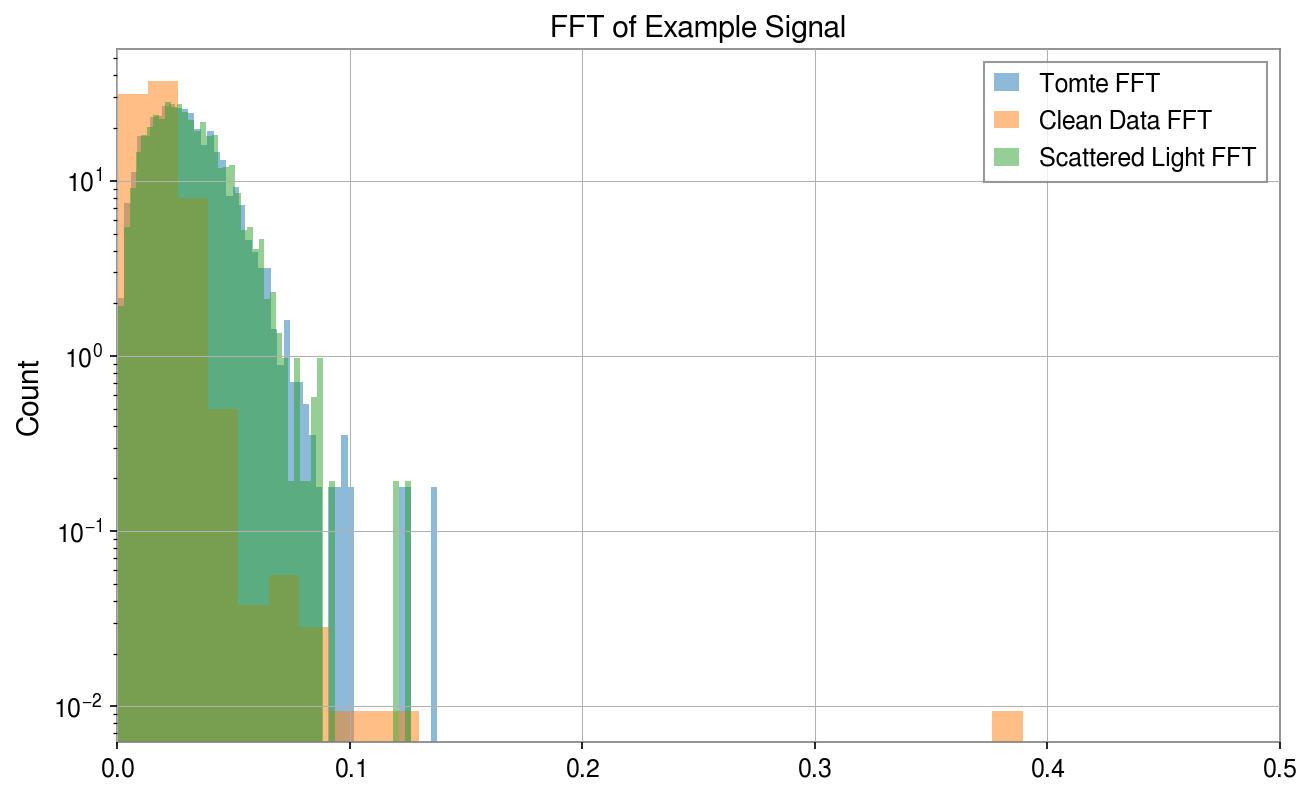

In [76]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(np.abs(eg_fft.value), label="Tomte FFT", bins=50, density=True, alpha=0.5)
plt.hist(np.abs(eg_fft2.value), label="Clean Data FFT", bins=50, density=True, alpha=0.5)
plt.hist(np.abs(eg_fft3.value), label="Scattered Light FFT", bins=50, density=True, alpha=0.5)
plt.yscale('log')
plt.xlim(0,0.5)
plt.ylabel("Count")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

In [77]:
example

whitened_y                  [0.2661297016194457, -1.6337597134818587, -1.5...
t                           [1246837198.270996 s, 1246837198.2712402 s, 12...
timeseries_file_location     ./timeseries_data/sample_L1_1246837203.771_10.h5
unwhitened_y                [3.94016537185416e-20, -1.1546895407459572e-20...
shapiro_statistic                                                     0.99990
shapiro_pvalue                                                        0.08496
ks_statistic                                                          0.00366
ks_pvalue                                                             0.58105
ad_statistic                                                          0.58837
ad_critical_values                        [0.576, 0.656, 0.787, 0.918, 1.092]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              3.02761
skew                                                            

In [78]:
example2

whitened_y                  [-1.0445034733494019, -0.03988255036441557, -0...
t                           [1239082671.3659668 s, 1239082671.366211 s, 12...
timeseries_file_location    ./timeseries_data/sample_L1_1239082665.3662078...
unwhitened_y                [5.438241096999612e-20, 4.962839640503188e-20,...
shapiro_statistic                                                     0.99916
shapiro_pvalue                                                        0.04550
ks_statistic                                                          0.00945
ks_pvalue                                                             0.85394
ad_statistic                                                          0.44434
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              3.12244
skew                                                            

In [79]:
example3

whitened_y                  [-0.7807687620893041, -0.13397790884924551, -1...
t                           [1243619993.2338867 s, 1243619993.2341309 s, 1...
timeseries_file_location     ./timeseries_data/sample_L1_1243619998.734_10.h5
unwhitened_y                [6.700831906626312e-20, 8.618903391866825e-20,...
shapiro_statistic                                                     0.99993
shapiro_pvalue                                                        0.34914
ks_statistic                                                          0.00290
ks_pvalue                                                             0.84292
ad_statistic                                                          0.38210
ad_critical_values                        [0.576, 0.656, 0.787, 0.918, 1.092]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              2.96948
skew                                                            

In [80]:
eg_q_transform, eg_time = statistical_testing.calculate_q_transform(example_ts)
eg_q_transform2, eg_time2 = statistical_testing.calculate_q_transform(example_ts2)
eg_q_transform3, eg_time3 = statistical_testing.calculate_q_transform(example_ts3)

print(eg_time,eg_time2,eg_time3)

0.14162826538085938 0.29165053367614746 0.13825654983520508


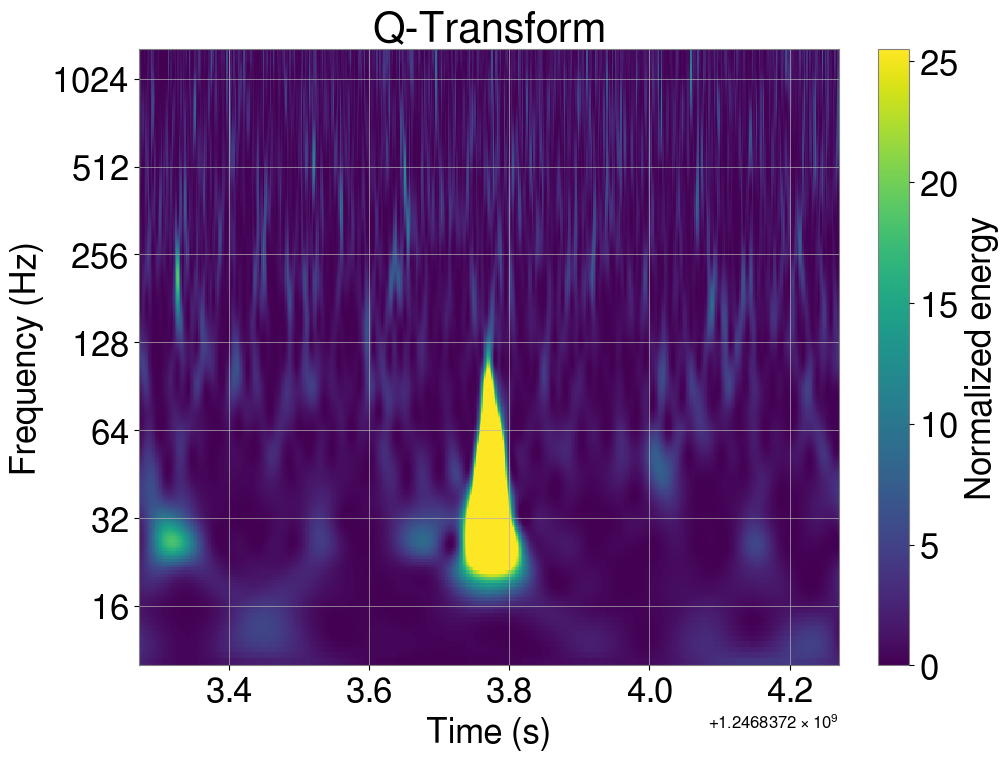

In [81]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

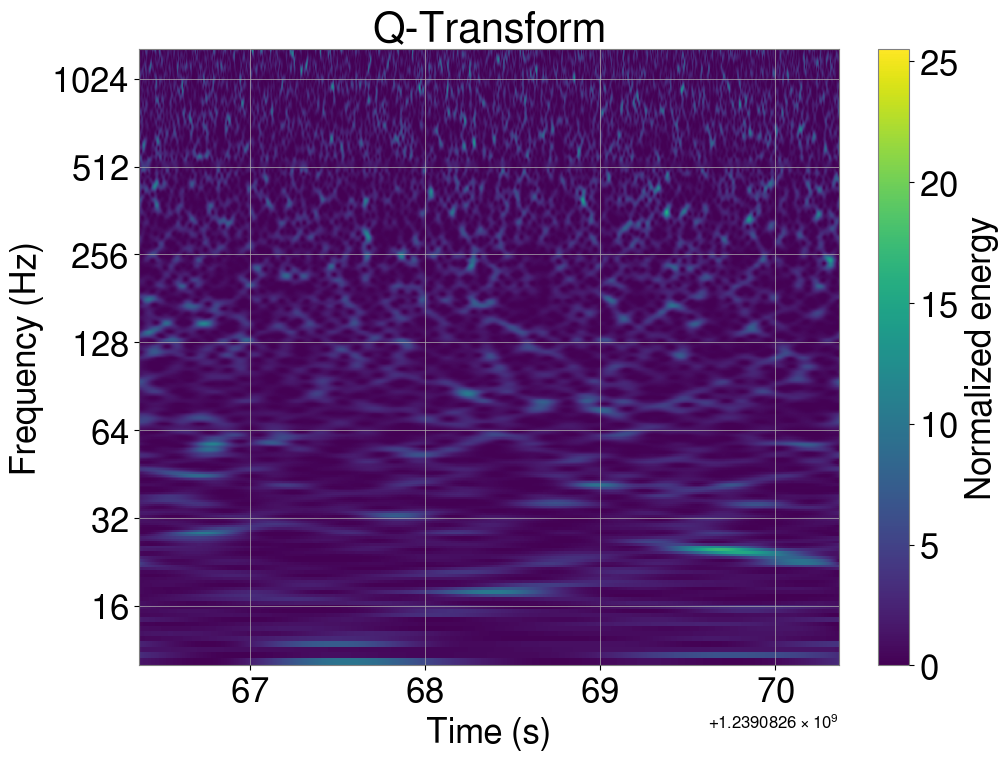

In [82]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform2)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

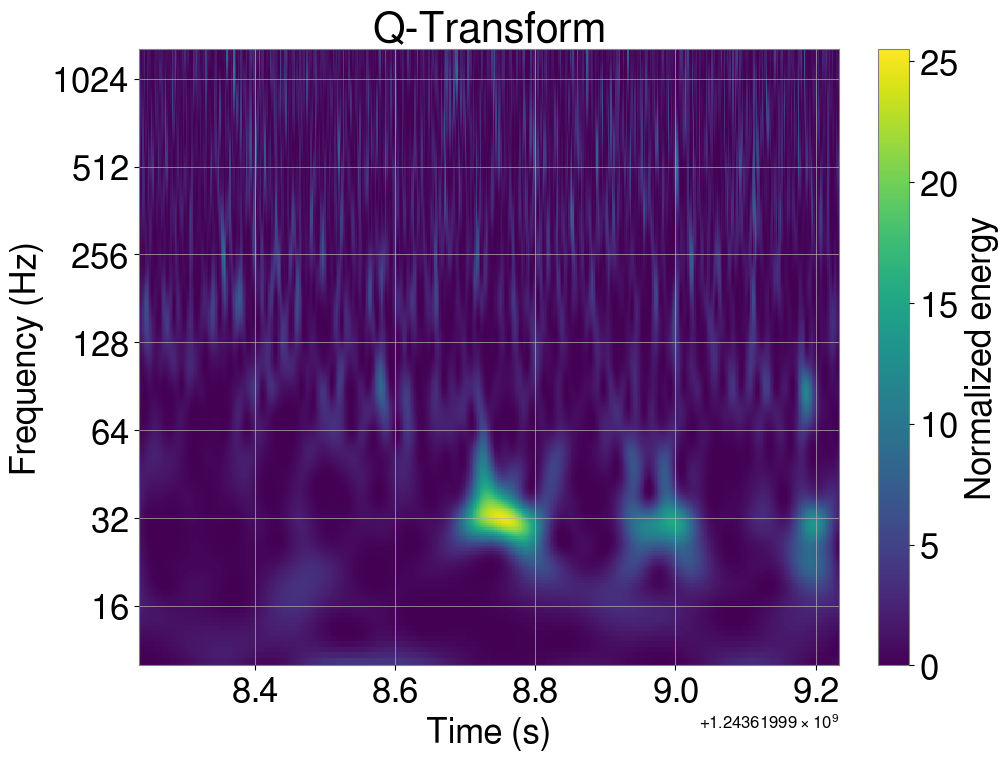

In [83]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform3)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

# Plots for the report

1. Gaussian Distribution

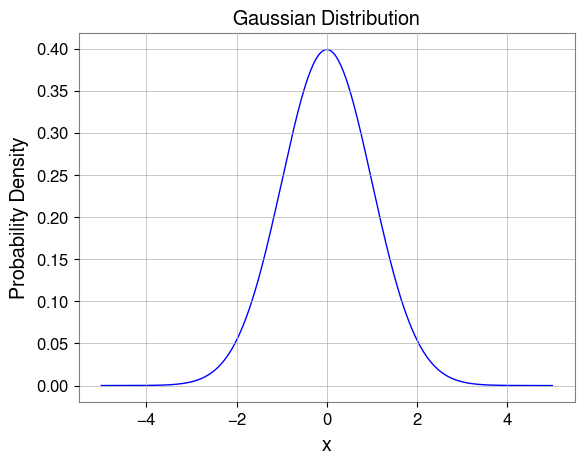

In [20]:
x = np.linspace(-5, 5, 1000)

mean = 0
stddev = 1

pdf = stats.norm.pdf(x, mean, stddev)

plt.plot(x, pdf, color='blue', linewidth=1)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution')
plt.grid(True)
plt.savefig("./outputs/gaussian_distribution.pdf", dpi=100)

2. Speed comparison for generating Q-transforms for different TimeSeries lengths

In [21]:
from gwosc.datasets import event_gps

gw150914_gpstime = event_gps('GW150914')

window_sizes = [4, 6, 8, 10, 12, 14, 16, 18, 20]

q_transform_times = []

# Loading TimeSeries data for GW150914

for window_size in window_sizes:
    gw_ts = TimeSeries.fetch_open_data('L1', gw150914_gpstime - window_size, gw150914_gpstime + window_size)
    gw_ts = gw_ts[int(4096):-int(4096)]
    gw_ts = gw_ts.whiten(4, 2)
    _, time = statistical_testing.calculate_q_transform(gw_ts)
    q_transform_times.append(time)

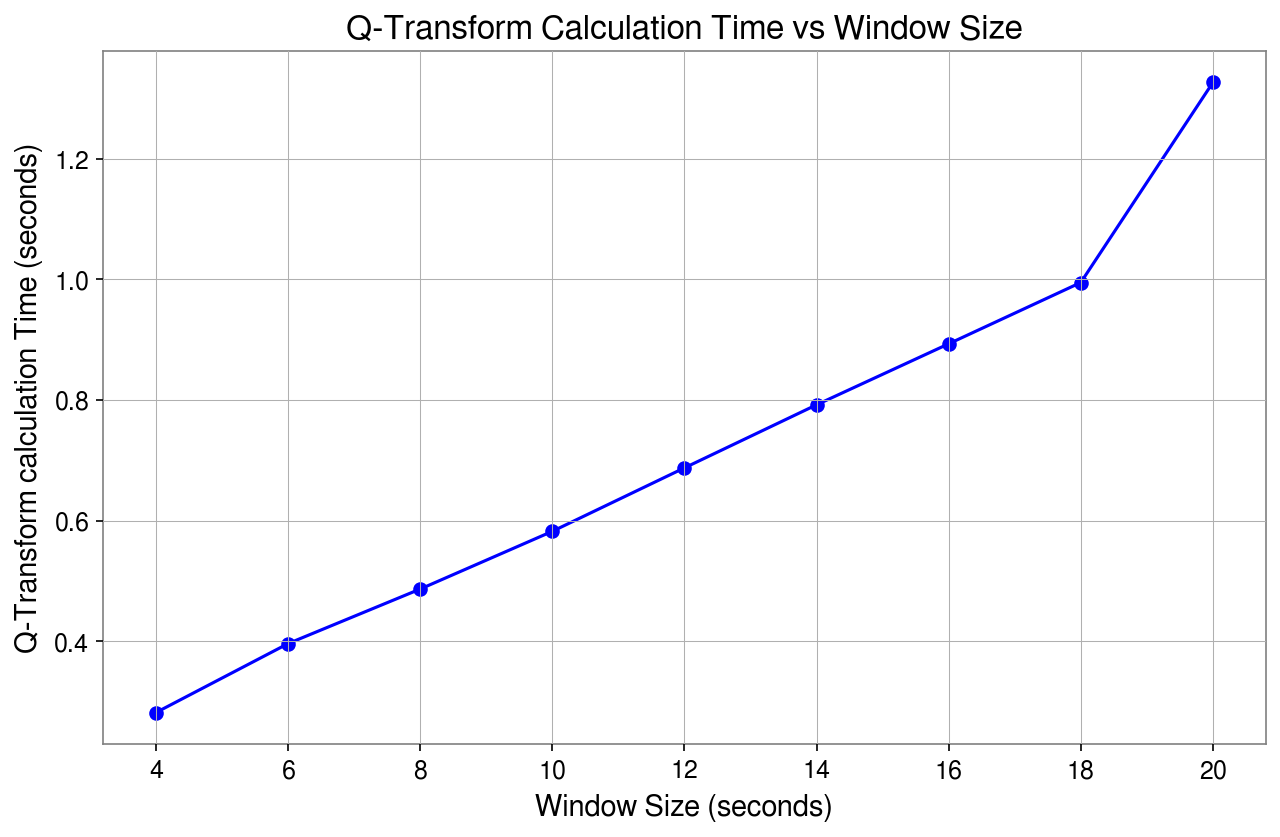

In [22]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(window_sizes, q_transform_times, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Window Size (seconds)', fontsize=14)
ax.set_ylabel('Q-Transform calculation Time (seconds)', fontsize=14)
ax.set_title('Q-Transform Calculation Time vs Window Size', fontsize=16)
ax.grid(True)
plt.xticks(window_sizes)
plt.savefig("./outputs/q_transform_time_vs_window_size.pdf", dpi=100)

3. Speed comparison of generating Q-transforms at a constant sample length but increasing number of samples 

In [23]:
glitch_sample_df = combined_df.loc[combined_df['label'] != 'clean_signal']


sample_counts = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

q_transform_times = []

for sample_count in sample_counts:
    time = 0
    sample_df = glitch_sample_df.sample(sample_count)
    for index, row in sample_df.iterrows():
        ts = TimeSeries.read(row["timeseries_file_location"])
        ts = ts.whiten(4, 2)
        ts = ts[int(4096):-int(4096)]
        _, t = statistical_testing.calculate_q_transform(ts)
        time += t
    q_transform_times.append(time)

# example_ts3 = statistical_testing.get_sample_glitch_from_filepath(example3["timeseries_file_location"])[1]

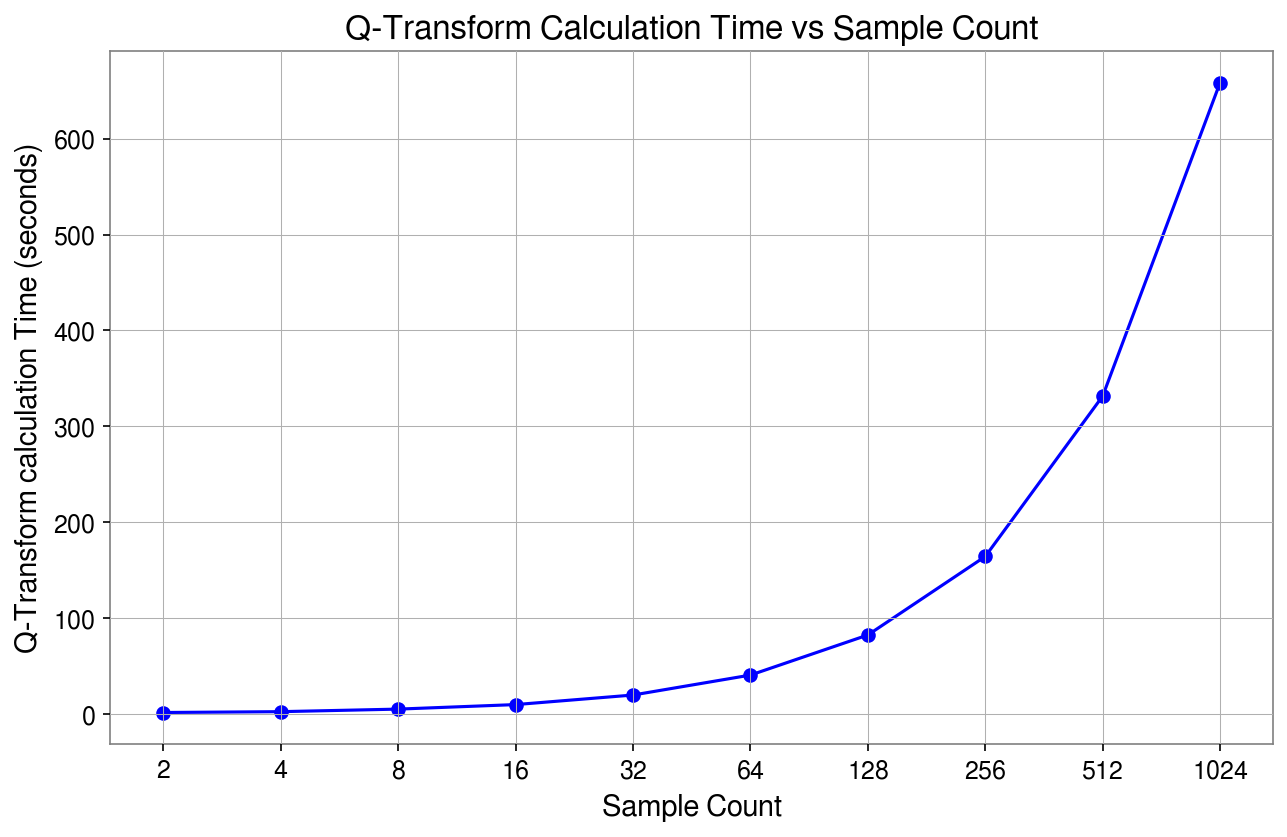

In [31]:
from matplotlib.ticker import LogLocator

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(sample_counts, q_transform_times, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Sample Count', fontsize=14)
ax.set_ylabel('Q-Transform calculation Time (seconds)', fontsize=14)
ax.set_title('Q-Transform Calculation Time vs Sample Count', fontsize=16)
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_xticks(sample_counts)
plt.savefig("./outputs/q_transform_time_vs_sample_count.pdf", dpi=100)